<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/bintu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
# Google Colab Specific Imports
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class'):
        """
        Initializes the dataset by creating a list of sequences from the DataFrame.

        Parameters:
        - df: DataFrame containing clone_id, node features, and class labels.
        - feature_start_col: Column name indicating the start of the node feature columns.
        - feature_end_col: Column name indicating the end of the node feature columns.
        - class_col: Column name for the label. Defaults to 'Class'.
        """
        self.sequences = []

        # Group the DataFrame by clone_id
        for clone_id, group in df.groupby('ID'):
            # Extract node features and concatenate them into one sequence vector
            node_features = group.loc[:, feature_start_col:feature_end_col].values
            sequence_vector = torch.tensor(node_features.flatten(), dtype=torch.float)

            # Assign the mean label to the sequence
            label = torch.tensor(group[class_col].mean(), dtype=torch.float)

            # Append the sequence, label, and clone_id as a dictionary
            self.sequences.append({'sequence': sequence_vector, 'label': label, 'ID': clone_id})

    def __len__(self):
        # Return the number of sequences
        return len(self.sequences)

    def __getitem__(self, idx):
        # Retrieve a single sequence and its label
        data = self.sequences[idx]
        return data['sequence'], data['label'], data['ID']


# # Check the shape of sequences_padded before passing to model
# for batch in dataloader:
#     sequences_padded, labels, attention_mask, clone_ids = batch
#     print(f"sequences_padded shape: {sequences_padded.shape}")  # Should be (batch_size, max_seq_len, input_dim)
#     print(f"Expected input_dim: {input_dim}")
#     logits = model(sequences_padded, attention_mask=attention_mask)  # This should now match
#     break




import torch
import torch.nn as nn

class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(TransformerBinaryClassifier, self).__init__()

        # Linear layer to project input features to the transformer dimension
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=hidden_dim * 4
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      # x shape: (batch_size, input_dim) or (batch_size, sequence_length, input_dim)

      # Embed input features
      x = self.embedding(x)  # Shape: (batch_size, sequence_length, hidden_dim) or (batch_size, hidden_dim)

      # Ensure x has three dimensions
      if x.dim() == 2:
          x = x.unsqueeze(1)  # Shape: (batch_size, 1, hidden_dim)

      # Permute for transformer input (transformer expects shape: [sequence_length, batch_size, hidden_dim])
      x = x.permute(1, 0, 2)

      # Pass through the transformer encoder
      x = self.transformer(x)

      # Permute back: (batch_size, sequence_length, hidden_dim)
      x = x.permute(1, 0, 2)

      # Pool over the sequence dimension
      x = x.mean(dim=1)  # Shape: (batch_size, hidden_dim)

      # Classification head
      logits = self.classifier(x).squeeze(-1)  # Shape: (batch_size,)

      return logits
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=8, num_layers=4, hidden_dim=128, dropout=0.1):
        super(TransformerBinaryClassifier, self).__init__()

        # Linear layer to project input features to the transformer dimension
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=hidden_dim * 6  # Increase feedforward dimension
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head with additional layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Embed input features
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, hidden_dim)

        # Ensure x has three dimensions
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape: (batch_size, 1, hidden_dim)

        # Permute for transformer input (transformer expects shape: [sequence_length, batch_size, hidden_dim])
        x = x.permute(1, 0, 2)

        # Pass through the transformer encoder
        x = self.transformer(x)

        # Permute back: (batch_size, sequence_length, hidden_dim)
        x = x.permute(1, 0, 2)

        # Use max pooling instead of mean pooling
        x = x.max(dim=1).values  # Shape: (batch_size, hidden_dim)

        # Classification head
        logits = self.classifier(x).squeeze(-1)  # Shape: (batch_size,)

        return logits


import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Plot Confusion Matrix function
def plot_confusion_matrix(true_labels, predicted_labels, class_names, save_path=None):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
        print(f'Saved confusion matrix plot to {save_path}')
    plt.close()

In [26]:
data = '/content/drive/My Drive/Disorder/Input_data/BINTU_FULL.csv'
df = pd.read_csv(data)
df = df.iloc[:,1:]
df.head()

,ID,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,...,net_charge,WF_complexity,KL_hydropathy,isoelectric_point,FCR,ED_ratio,RK_ratio,SCD,omega*,Class
0,ABRAXAS1-Q6UWZ7-121-200,-0.387436,-0.369605,-0.042491,-0.545608,-0.649255,-0.479691,-0.611583,-0.551053,-0.586244,...,0.357382,-0.121465,1.270419,0.574372,-1.289988,0.790123,0.179887,-0.371136,-0.468941,1
1,AHR-P35869-531-720,6.502046,-0.369605,-0.042491,-0.545608,-0.649255,-0.479691,-0.611583,-0.551053,-0.586244,...,-1.405510,1.404268,-0.742440,-0.869480,-0.535635,-1.030195,-1.008700,0.603091,0.610772,1
2,AKAP8-O43823-1-80,-0.387436,-0.369605,-0.737793,1.577840,-0.649255,-0.479691,-0.611583,-0.551053,-0.586244,...,-0.112723,-2.302088,0.065899,-1.053567,-2.195212,-0.595241,-0.719245,-0.244111,-0.227271,1
3,AKAP8L-Q9ULX6-1-80,-0.387436,-0.369605,-0.042491,-0.545608,-0.649255,-0.479691,-0.611583,-0.551053,-0.586244,...,-0.465301,-1.807676,-1.350800,-1.232564,-1.742600,-0.932618,1.079018,-0.010697,0.199334,1
4,APBB1-O00213-221-330,-0.387436,-0.369605,0.652811,-0.545608,0.039929,-0.479691,-0.611583,-0.551053,0.178026,...,-1.758089,-0.104256,-1.270973,-1.269890,-0.425911,-0.319584,0.705845,1.270293,0.327953,1


In [27]:
# Usage example:
start = "REP_Q2"
end = "omega*"
# Initialize the dataset with the cleaned DataFrame
dataset = SequenceDataset(df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class')

# Define a DataLoader to iterate over the dataset in batches
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [43]:
first_sequence, _, _ = dataset[0]
input_dim = first_sequence.shape[-1]
hidden_dim = 64  # Set as needed for the model
num_heads = 4    # Set as needed for the model
num_layers = 2   # Set as needed for the model
# Check the shape of sequences_padded before passing to model
model = TransformerBinaryClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
results = []

# Retrieve input dimension from the first sample in the dataset
first_sequence, _, _ = dataset[0]  # Adjust as needed to fit your dataset structure
input_dim = first_sequence.shape[-1]  # This gives the number of features per token

# Define model parameters
hidden_dim = 64
num_heads = 4
num_layers = 2

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"FOLD {fold + 1}/{k_folds}")

    # Create train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # DataLoaders for train and validation subsets
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model, loss function, and optimizer for each fold
    model = TransformerBinaryClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop for each epoch
    for epoch in range(3):  # Adjust the number of epochs as needed
        model.train()
        for batch in train_loader:
            sequences, labels, _ = batch  # Adjust to retrieve padded sequences and labels
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            loss = criterion(logits, labels.float())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            sequences, labels, _ = batch
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            predictions = (logits > 0.5).float()  # Convert probabilities to binary predictions
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    # Calculate confusion matrix and metrics
    tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
    accuracy = (tp + tn) / (tp + fp + fn + tn)

    # Print metrics for this fold
    print(f"Fold {fold + 1} Metrics:")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  True Negatives: {tn}")
    print(f"  False Negatives: {fn}")
    print(f"  Accuracy: {accuracy:.4f}\n")

    # Save metrics for this fold
    results.append({
        'Fold': fold + 1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Accuracy': accuracy
    })

# Print results for each fold
print("\nCross-Validation Results:")
for result in results:
    print(f"Fold {result['Fold']}:")
    print(f"  True Positives: {result['True Positives']}")
    print(f"  False Positives: {result['False Positives']}")
    print(f"  True Negatives: {result['True Negatives']}")
    print(f"  False Negatives: {result['False Negatives']}")
    print(f"  Accuracy: {result['Accuracy']:.4f}")

# Calculate and print the average accuracy across all folds
avg_accuracy = sum(result['Accuracy'] for result in results) / k_folds
print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")


FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 1 Metrics:
  True Positives: 17
  False Positives: 11
  True Negatives: 426
  False Negatives: 49
  Accuracy: 0.8807

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Metrics:
  True Positives: 25
  False Positives: 13
  True Negatives: 421
  False Negatives: 44
  Accuracy: 0.8867

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Metrics:
  True Positives: 25
  False Positives: 15
  True Negatives: 431
  False Negatives: 31
  Accuracy: 0.9084

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Metrics:
  True Positives: 21
  False Positives: 16
  True Negatives: 423
  False Negatives: 42
  Accuracy: 0.8845

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Metrics:
  True Positives: 11
  False Positives: 7
  True Negatives: 433
  False Negatives: 51
  Accuracy: 0.8845


Cross-Validation Results:
Fold 1:
  True Positives: 17
  False Positives: 11
  True Negatives: 426
  False Negatives: 49
  Accuracy: 0.8807
Fold 2:
  True Positives: 25
  False Positives: 13
  True Negatives: 421
  False Negatives: 44
  Accuracy: 0.8867
Fold 3:
  True Positives: 25
  False Positives: 15
  True Negatives: 431
  False Negatives: 31
  Accuracy: 0.9084
Fold 4:
  True Positives: 21
  False Positives: 16
  True Negatives: 423
  False Negatives: 42
  Accuracy: 0.8845
Fold 5:
  True Positives: 11
  False Positives: 7
  True Negatives: 433
  False Negatives: 51
  Accuracy: 0.8845

Average Validation Accuracy: 0.8889


FOLD 1/5
Fold 1 Metrics:
  True Positives: 35
  False Positives: 19
  True Negatives: 418
  False Negatives: 31
  Accuracy: 0.9006



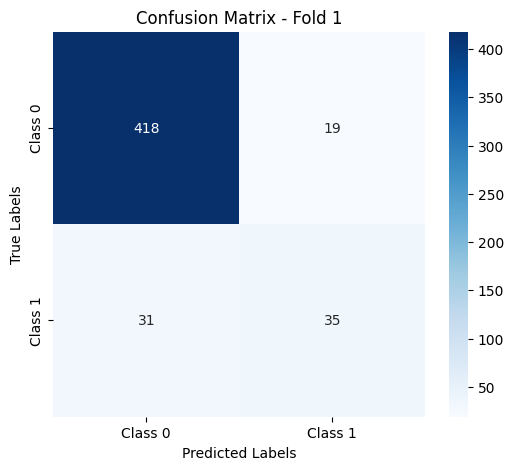

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Metrics:
  True Positives: 30
  False Positives: 15
  True Negatives: 419
  False Negatives: 39
  Accuracy: 0.8926



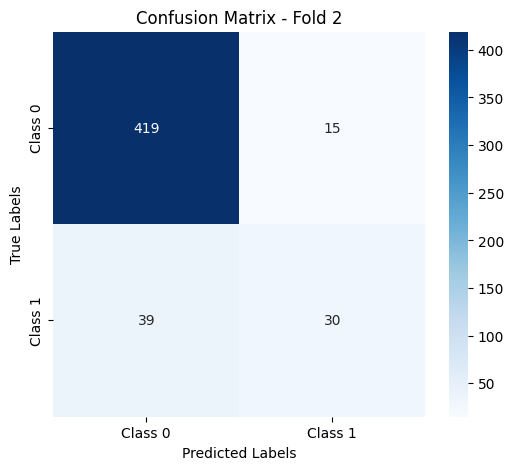

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Metrics:
  True Positives: 36
  False Positives: 24
  True Negatives: 422
  False Negatives: 20
  Accuracy: 0.9124



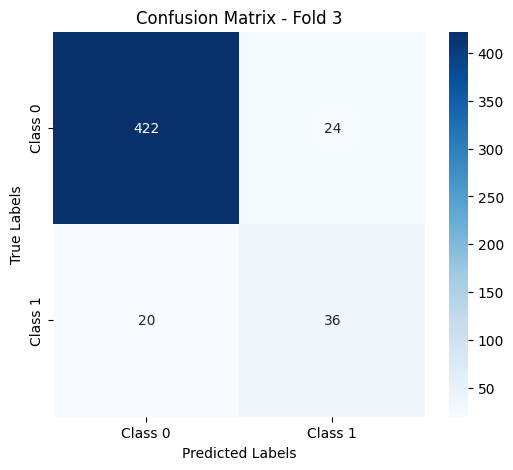

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Metrics:
  True Positives: 31
  False Positives: 33
  True Negatives: 406
  False Negatives: 32
  Accuracy: 0.8705



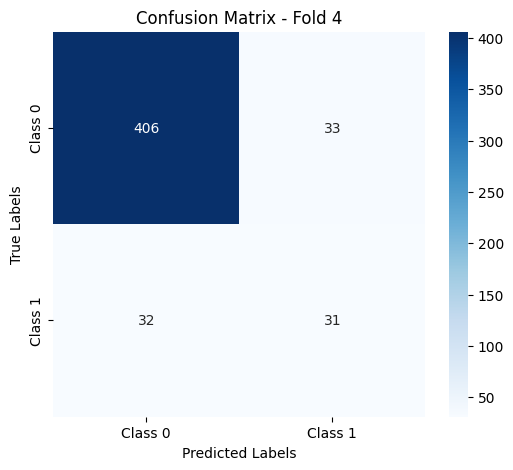

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Metrics:
  True Positives: 28
  False Positives: 18
  True Negatives: 422
  False Negatives: 34
  Accuracy: 0.8964



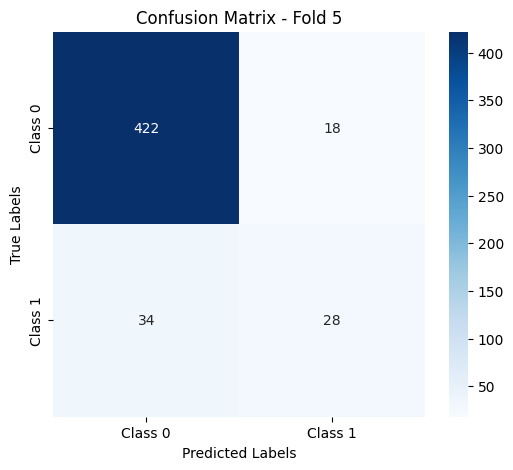


Average Validation Accuracy: 0.8945


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
results = []

# Retrieve input dimension from the first sample in the dataset
first_sequence, _, _ = dataset[0]  # Adjust as needed to fit your dataset structure
input_dim = first_sequence.shape[-1]  # This gives the number of features per token

# Define model parameters
hidden_dim = 64
num_heads = 4
num_layers = 2

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"FOLD {fold + 1}/{k_folds}")

    # Create train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # DataLoaders for train and validation subsets
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model, loss function, and optimizer for each fold
    model = TransformerBinaryClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop for each epoch
    for epoch in range(10):  # Adjust the number of epochs as needed
        model.train()
        for batch in train_loader:
            sequences, labels, _ = batch
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            loss = criterion(logits, labels.float())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            sequences, labels, _ = batch
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(sequences)
            predictions = (logits > 0.5).float()  # Convert probabilities to binary predictions
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    # Calculate confusion matrix and metrics
    tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
    accuracy = (tp + tn) / (tp + fp + fn + tn)

    # Print metrics for this fold
    print(f"Fold {fold + 1} Metrics:")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  True Negatives: {tn}")
    print(f"  False Negatives: {fn}")
    print(f"  Accuracy: {accuracy:.4f}\n")

    # Plot confusion matrix for this fold
    conf_matrix_data = np.array([[tn, fp], [fn, tp]])
    plot_confusion_matrix(conf_matrix_data, class_names=["Class 0", "Class 1"], title=f'Confusion Matrix - Fold {fold + 1}')

    # Save metrics for this fold
    results.append({
        'Fold': fold + 1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Accuracy': accuracy
    })

# Calculate and print the average accuracy across all folds
avg_accuracy = sum(result['Accuracy'] for result in results) / k_folds
print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Main function for training and cross-validation with experimental parameters
def train_and_evaluate_model(dataset, device, num_epochs=10, batch_size=32, learning_rate=1e-4,
                             hidden_dim=64, num_heads=4, num_layers=2, pos_weight=2.0, neg_weight=1.0, k_folds=5):

    # Retrieve input dimension from the first sample in the dataset
    first_sequence, _, _ = dataset[0]  # Adjust as needed to fit your dataset structure
    input_dim = first_sequence.shape[-1]  # This gives the number of features per token

    # Calculate dynamic class weights based on class distribution, if not provided
    if pos_weight is None or neg_weight is None:
        labels = [dataset[i][1] for i in range(len(dataset))]
        num_samples = len(labels)
        num_classes = 2
        class_counts = [labels.count(0), labels.count(1)]
        neg_weight = num_samples / (class_counts[0] * num_classes)
        pos_weight = num_samples / (class_counts[1] * num_classes)

    # Cross-validation setup
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"FOLD {fold + 1}/{k_folds}")

        # Create train and validation subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # DataLoaders for train and validation subsets
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer for each fold
        model = TransformerBinaryClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim).to(device)
        criterion = nn.BCELoss(reduction='none')  # Use reduction='none' to get per-sample losses
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Lists to record training/validation loss and accuracy (for monitoring)
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        # Training loop for each epoch
        for epoch in range(num_epochs):
            model.train()
            train_loss, correct_train, total_train = 0, 0, 0

            for batch in train_loader:
                sequences, labels, _ = batch
                sequences = sequences.to(device)
                labels = labels.to(device)

                # Create a weight tensor for each sample in the batch
                weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)

                # Forward pass
                logits = model(sequences).squeeze()
                loss_per_sample = criterion(logits, labels.float())
                loss = (loss_per_sample * weight).mean()  # Apply weights and take the mean

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate training loss and accuracy
                train_loss += loss.item() * sequences.size(0)
                preds = (logits > 0.5).float()
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            # Calculate average training loss and accuracy for the epoch
            train_losses.append(train_loss / total_train)
            train_accuracies.append(correct_train / total_train)

            # Validation loop
            model.eval()
            val_loss, correct_val, total_val = 0, 0, 0
            val_labels, val_preds = [], []

            with torch.no_grad():
                for batch in val_loader:
                    sequences, labels, _ = batch
                    sequences = sequences.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    logits = model(sequences).squeeze()
                    loss_per_sample = criterion(logits, labels.float())
                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                    # Predictions
                    predictions = (logits > 0.5).float()
                    correct_val += (predictions == labels).sum().item()
                    total_val += labels.size(0)
                    val_labels.extend(labels.cpu().numpy())
                    val_preds.extend(predictions.cpu().numpy())

            # Calculate average validation loss and accuracy for the epoch
            val_losses.append(val_loss / total_val)
            val_accuracies.append(correct_val / total_val)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Plot confusion matrix for the last epoch of this fold
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names=["Class 0", "Class 1"], title=f'Confusion Matrix - Fold {fold + 1}')

        # Save metrics for this fold
        results.append({
            'Fold': fold + 1,
            'Validation Accuracy': val_accuracies[-1],
            'Validation Loss': val_losses[-1]
        })

    # Calculate and print the average accuracy across all folds
    avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
    print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")

    # Return training and validation losses and accuracies for plotting or further analysis
    return train_losses, val_losses, train_accuracies, val_accuracies


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Main function for training and cross-validation with experimental parameters
def train_and_evaluate_model(dataset, device, num_epochs=10, batch_size=32, learning_rate=1e-4,
                             hidden_dim=64, num_heads=4, num_layers=2, pos_weight=2.0, neg_weight=1.0,
                             k_folds=5, augment_minority_class=False):

    # Retrieve input dimension from the first sample in the dataset
    first_sequence, _, _ = dataset[0]  # Adjust as needed to fit your dataset structure
    input_dim = first_sequence.shape[-1]  # This gives the number of features per token

    # Calculate dynamic class weights based on class distribution, if not provided
    if pos_weight is None or neg_weight is None:
        labels = [dataset[i][1] for i in range(len(dataset))]
        num_samples = len(labels)
        num_classes = 2
        class_counts = [labels.count(0), labels.count(1)]
        neg_weight = num_samples / (class_counts[0] * num_classes)
        pos_weight = num_samples / (class_counts[1] * num_classes)

    # Cross-validation setup
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"FOLD {fold + 1}/{k_folds}")

        # Create train and validation subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Augment Class 1 samples in the training set if specified
        if augment_minority_class:
            class_1_indices = [i for i in train_idx if dataset[i][1] == 1]  # Find indices of Class 1 samples
            class_1_subset = Subset(dataset, class_1_indices)
            train_subset = ConcatDataset([train_subset, class_1_subset])  # Concatenate original and augmented class 1 data

        # DataLoaders for train and validation subsets
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer for each fold
        model = TransformerBinaryClassifier(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim).to(device)
        criterion = nn.BCELoss(reduction='none')  # Use reduction='none' to get per-sample losses
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Lists to record training/validation loss and accuracy (for monitoring)
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        # Training loop for each epoch
        for epoch in range(num_epochs):
            model.train()
            train_loss, correct_train, total_train = 0, 0, 0

            for batch in train_loader:
                sequences, labels, _ = batch
                sequences = sequences.to(device)
                labels = labels.to(device)

                # Create a weight tensor for each sample in the batch
                weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)

                # Forward pass
                logits = model(sequences).squeeze()
                loss_per_sample = criterion(logits, labels.float())
                loss = (loss_per_sample * weight).mean()  # Apply weights and take the mean

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate training loss and accuracy
                train_loss += loss.item() * sequences.size(0)
                preds = (logits > 0.5).float()
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            # Calculate average training loss and accuracy for the epoch
            train_losses.append(train_loss / total_train)
            train_accuracies.append(correct_train / total_train)

            # Validation loop
            model.eval()
            val_loss, correct_val, total_val = 0, 0, 0
            val_labels, val_preds = [], []

            with torch.no_grad():
                for batch in val_loader:
                    sequences, labels, _ = batch
                    sequences = sequences.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    logits = model(sequences).squeeze()
                    loss_per_sample = criterion(logits, labels.float())
                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                    # Predictions
                    predictions = (logits > 0.5).float()
                    correct_val += (predictions == labels).sum().item()
                    total_val += labels.size(0)
                    val_labels.extend(labels.cpu().numpy())
                    val_preds.extend(predictions.cpu().numpy())

            # Calculate average validation loss and accuracy for the epoch
            val_losses.append(val_loss / total_val)
            val_accuracies.append(correct_val / total_val)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Plot confusion matrix for the last epoch of this fold
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names=["Class 0", "Class 1"], title=f'Confusion Matrix - Fold {fold + 1}')

        # Save metrics for this fold
        results.append({
            'Fold': fold + 1,
            'Validation Accuracy': val_accuracies[-1],
            'Validation Loss': val_losses[-1]
        })

    # Calculate and print the average accuracy across all folds
    avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
    print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")

    # Return training and validation losses and accuracies for plotting or further analysis
    return train_losses, val_losses, train_accuracies, val_accuracies


In [49]:
first_sequence, _, _ = dataset[0]
input_dim = first_sequence.shape[-1]
num_heads = 8         # Number of attention heads
num_layers = 4        # Number of transformer layers
hidden_dim = 128      # Hidden dimension size
dropout = 0.1         # Dropout rate
model = TransformerBinaryClassifier(
    input_dim=input_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    dropout=dropout
).to(device)  # Move to device (e.g., GPU) if available

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Train Loss: 0.5977, Val Loss: 0.4390, Train Acc: 0.7211, Val Acc: 0.8688
Epoch [2/15], Train Loss: 0.4752, Val Loss: 0.3531, Train Acc: 0.7813, Val Acc: 0.8787
Epoch [3/15], Train Loss: 0.4094, Val Loss: 0.3089, Train Acc: 0.8092, Val Acc: 0.8986
Epoch [4/15], Train Loss: 0.3636, Val Loss: 0.2892, Train Acc: 0.8415, Val Acc: 0.8926
Epoch [5/15], Train Loss: 0.3350, Val Loss: 0.2744, Train Acc: 0.8552, Val Acc: 0.8926
Epoch [6/15], Train Loss: 0.3168, Val Loss: 0.2760, Train Acc: 0.8699, Val Acc: 0.8867
Epoch [7/15], Train Loss: 0.3001, Val Loss: 0.2721, Train Acc: 0.8725, Val Acc: 0.8807
Epoch [8/15], Train Loss: 0.2854, Val Loss: 0.2598, Train Acc: 0.8800, Val Acc: 0.9006
Epoch [9/15], Train Loss: 0.2749, Val Loss: 0.2635, Train Acc: 0.8889, Val Acc: 0.8946
Epoch [10/15], Train Loss: 0.2690, Val Loss: 0.2647, Train Acc: 0.8898, Val Acc: 0.8946
Epoch [11/15], Train Loss: 0.2590, Val Loss: 0.2636, Train Acc: 0.8982, Val Acc: 0.8926
Epoch [12/15], Train Loss: 0.2545, Val Lo

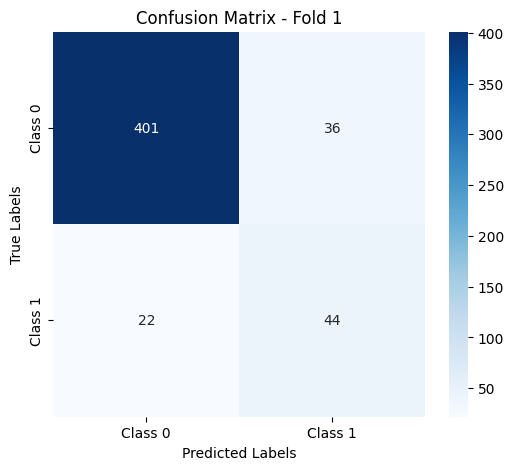

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Train Loss: 0.5936, Val Loss: 0.4442, Train Acc: 0.7163, Val Acc: 0.8608
Epoch [2/15], Train Loss: 0.4705, Val Loss: 0.3570, Train Acc: 0.7859, Val Acc: 0.8708
Epoch [3/15], Train Loss: 0.4027, Val Loss: 0.3062, Train Acc: 0.8311, Val Acc: 0.9026
Epoch [4/15], Train Loss: 0.3563, Val Loss: 0.2829, Train Acc: 0.8604, Val Acc: 0.8907
Epoch [5/15], Train Loss: 0.3241, Val Loss: 0.2695, Train Acc: 0.8710, Val Acc: 0.8926
Epoch [6/15], Train Loss: 0.3074, Val Loss: 0.2635, Train Acc: 0.8790, Val Acc: 0.8926
Epoch [7/15], Train Loss: 0.2949, Val Loss: 0.2695, Train Acc: 0.8852, Val Acc: 0.8787
Epoch [8/15], Train Loss: 0.2849, Val Loss: 0.2614, Train Acc: 0.8932, Val Acc: 0.8946
Epoch [9/15], Train Loss: 0.2789, Val Loss: 0.2627, Train Acc: 0.8949, Val Acc: 0.8887
Epoch [10/15], Train Loss: 0.2708, Val Loss: 0.2624, Train Acc: 0.9016, Val Acc: 0.8867
Epoch [11/15], Train Loss: 0.2635, Val Loss: 0.2654, Train Acc: 0.9060, Val Acc: 0.8887
Epoch [12/15], Train Loss: 0.2573, Val Lo

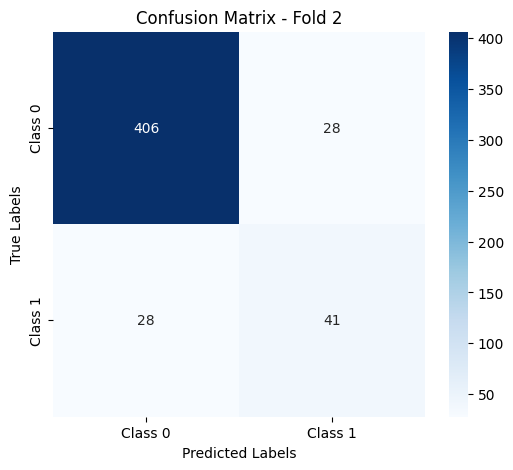

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Train Loss: 0.6087, Val Loss: 0.4596, Train Acc: 0.7163, Val Acc: 0.8865
Epoch [2/15], Train Loss: 0.4982, Val Loss: 0.3703, Train Acc: 0.7753, Val Acc: 0.8884
Epoch [3/15], Train Loss: 0.4314, Val Loss: 0.3284, Train Acc: 0.8185, Val Acc: 0.8984
Epoch [4/15], Train Loss: 0.3831, Val Loss: 0.3012, Train Acc: 0.8401, Val Acc: 0.8904
Epoch [5/15], Train Loss: 0.3523, Val Loss: 0.2837, Train Acc: 0.8546, Val Acc: 0.8865
Epoch [6/15], Train Loss: 0.3314, Val Loss: 0.2718, Train Acc: 0.8665, Val Acc: 0.8884
Epoch [7/15], Train Loss: 0.3162, Val Loss: 0.2775, Train Acc: 0.8767, Val Acc: 0.8785
Epoch [8/15], Train Loss: 0.3077, Val Loss: 0.2646, Train Acc: 0.8784, Val Acc: 0.8845
Epoch [9/15], Train Loss: 0.2961, Val Loss: 0.2738, Train Acc: 0.8824, Val Acc: 0.8765
Epoch [10/15], Train Loss: 0.2887, Val Loss: 0.2795, Train Acc: 0.8943, Val Acc: 0.8765
Epoch [11/15], Train Loss: 0.2815, Val Loss: 0.2749, Train Acc: 0.8978, Val Acc: 0.8785
Epoch [12/15], Train Loss: 0.2775, Val Lo

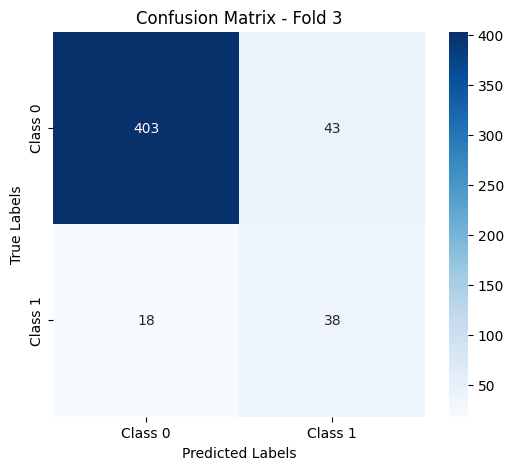

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Train Loss: 0.6118, Val Loss: 0.4727, Train Acc: 0.6818, Val Acc: 0.8725
Epoch [2/15], Train Loss: 0.4732, Val Loss: 0.3829, Train Acc: 0.7954, Val Acc: 0.8745
Epoch [3/15], Train Loss: 0.4004, Val Loss: 0.3393, Train Acc: 0.8325, Val Acc: 0.8566
Epoch [4/15], Train Loss: 0.3582, Val Loss: 0.3354, Train Acc: 0.8471, Val Acc: 0.8466
Epoch [5/15], Train Loss: 0.3347, Val Loss: 0.3115, Train Acc: 0.8639, Val Acc: 0.8606
Epoch [6/15], Train Loss: 0.3129, Val Loss: 0.3123, Train Acc: 0.8785, Val Acc: 0.8566
Epoch [7/15], Train Loss: 0.3000, Val Loss: 0.3142, Train Acc: 0.8772, Val Acc: 0.8566
Epoch [8/15], Train Loss: 0.2846, Val Loss: 0.3211, Train Acc: 0.8904, Val Acc: 0.8546
Epoch [9/15], Train Loss: 0.2769, Val Loss: 0.2989, Train Acc: 0.8944, Val Acc: 0.8625
Epoch [10/15], Train Loss: 0.2685, Val Loss: 0.3065, Train Acc: 0.8944, Val Acc: 0.8566
Epoch [11/15], Train Loss: 0.2585, Val Loss: 0.3107, Train Acc: 0.9023, Val Acc: 0.8606
Epoch [12/15], Train Loss: 0.2516, Val Lo

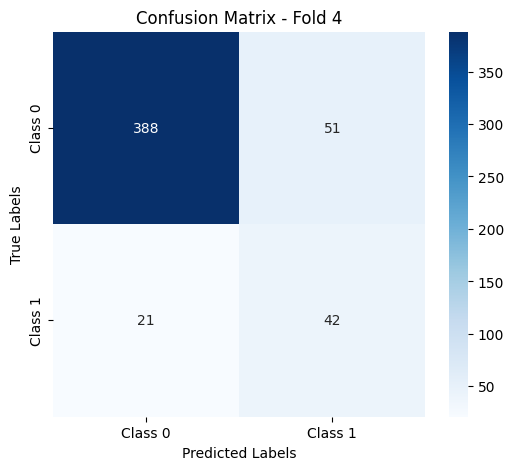

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Train Loss: 0.6075, Val Loss: 0.4663, Train Acc: 0.7133, Val Acc: 0.8745
Epoch [2/15], Train Loss: 0.4913, Val Loss: 0.3765, Train Acc: 0.7796, Val Acc: 0.8805
Epoch [3/15], Train Loss: 0.4264, Val Loss: 0.3328, Train Acc: 0.8074, Val Acc: 0.8924
Epoch [4/15], Train Loss: 0.3743, Val Loss: 0.3012, Train Acc: 0.8454, Val Acc: 0.8964
Epoch [5/15], Train Loss: 0.3413, Val Loss: 0.2918, Train Acc: 0.8604, Val Acc: 0.8825
Epoch [6/15], Train Loss: 0.3227, Val Loss: 0.2866, Train Acc: 0.8741, Val Acc: 0.8805
Epoch [7/15], Train Loss: 0.3061, Val Loss: 0.2761, Train Acc: 0.8825, Val Acc: 0.8884
Epoch [8/15], Train Loss: 0.2945, Val Loss: 0.2778, Train Acc: 0.8843, Val Acc: 0.8845
Epoch [9/15], Train Loss: 0.2857, Val Loss: 0.2790, Train Acc: 0.8918, Val Acc: 0.8884
Epoch [10/15], Train Loss: 0.2806, Val Loss: 0.2819, Train Acc: 0.8927, Val Acc: 0.8904
Epoch [11/15], Train Loss: 0.2760, Val Loss: 0.2778, Train Acc: 0.8953, Val Acc: 0.8904
Epoch [12/15], Train Loss: 0.2679, Val Lo

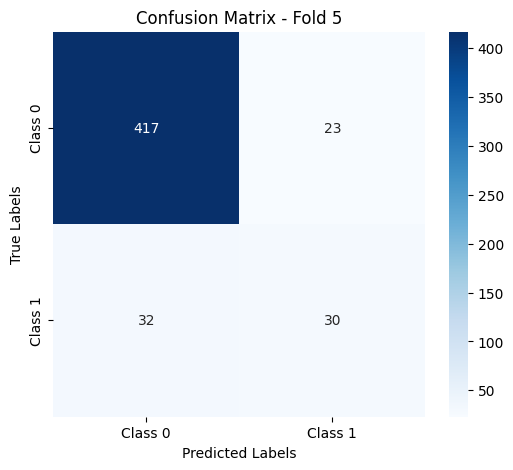


Average Validation Accuracy: 0.8798


In [50]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(
    dataset=dataset,
    device=device,
    num_epochs=15,
    batch_size=16,
    learning_rate=1e-5,
    hidden_dim=128,     # Match with the model initialization
    num_heads=8,        # Match with the model initialization
    num_layers=4,       # Match with the model initialization
    pos_weight=1.0,
    neg_weight=1.0,
    k_folds=5,
    augment_minority_class=True
)


Running Experiment 1 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6065, Val Loss: 0.4688, Train Acc: 0.7162, Val Acc: 0.8728
Epoch [2/50], Train Loss: 0.4879, Val Loss: 0.3800, Train Acc: 0.7862, Val Acc: 0.8847
Epoch [3/50], Train Loss: 0.4255, Val Loss: 0.3349, Train Acc: 0.8163, Val Acc: 0.9006
Epoch [4/50], Train Loss: 0.3732, Val Loss: 0.2965, Train Acc: 0.8570, Val Acc: 0.9026
Epoch [5/50], Train Loss: 0.3408, Val Loss: 0.2914, Train Acc: 0.8694, Val Acc: 0.9026
Epoch [6/50], Train Loss: 0.3172, Val Loss: 0.2781, Train Acc: 0.8858, Val Acc: 0.8926
Epoch [7/50], Train Loss: 0.3007, Val Loss: 0.2789, Train Acc: 0.8884, Val Acc: 0.8907
Epoch [8/50], Train Loss: 0.2905, Val Loss: 0.2658, Train Acc: 0.8986, Val Acc: 0.8966
Epoch [9/50], Train Loss: 0.2786, Val Loss: 0.2681, Train Acc: 0.8986, Val Acc: 0.8907
Epoch [10/50], Train Loss: 0.2733, Val Loss: 0.2618, Train Acc: 0.8969, Val Acc: 0.8966
Epoch [11/50], Train Loss: 0.2617, Val Loss: 0.2599, Train Acc: 0.9079, Val Acc: 0.9006
Epoch [12/50], Train Loss: 0.2557, Val Lo

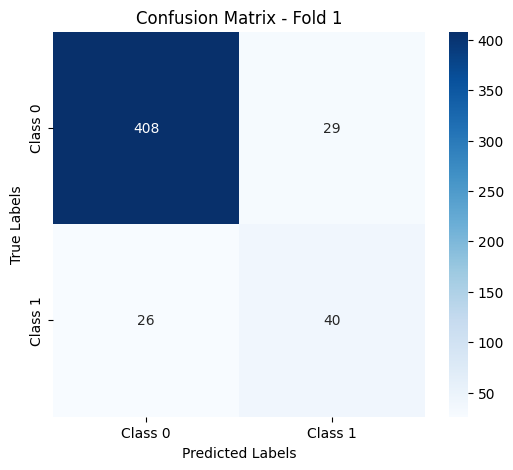

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5653, Val Loss: 0.4292, Train Acc: 0.7651, Val Acc: 0.8628
Epoch [2/50], Train Loss: 0.4513, Val Loss: 0.3435, Train Acc: 0.7863, Val Acc: 0.8688
Epoch [3/50], Train Loss: 0.3931, Val Loss: 0.3081, Train Acc: 0.8187, Val Acc: 0.8827
Epoch [4/50], Train Loss: 0.3507, Val Loss: 0.2876, Train Acc: 0.8497, Val Acc: 0.8847
Epoch [5/50], Train Loss: 0.3259, Val Loss: 0.2774, Train Acc: 0.8635, Val Acc: 0.8827
Epoch [6/50], Train Loss: 0.3064, Val Loss: 0.2709, Train Acc: 0.8768, Val Acc: 0.8867
Epoch [7/50], Train Loss: 0.2949, Val Loss: 0.2672, Train Acc: 0.8777, Val Acc: 0.8887
Epoch [8/50], Train Loss: 0.2802, Val Loss: 0.2645, Train Acc: 0.8910, Val Acc: 0.8867
Epoch [9/50], Train Loss: 0.2707, Val Loss: 0.2651, Train Acc: 0.8985, Val Acc: 0.8847
Epoch [10/50], Train Loss: 0.2626, Val Loss: 0.2606, Train Acc: 0.8967, Val Acc: 0.8907
Epoch [11/50], Train Loss: 0.2552, Val Loss: 0.2624, Train Acc: 0.9043, Val Acc: 0.8887
Epoch [12/50], Train Loss: 0.2501, Val Lo

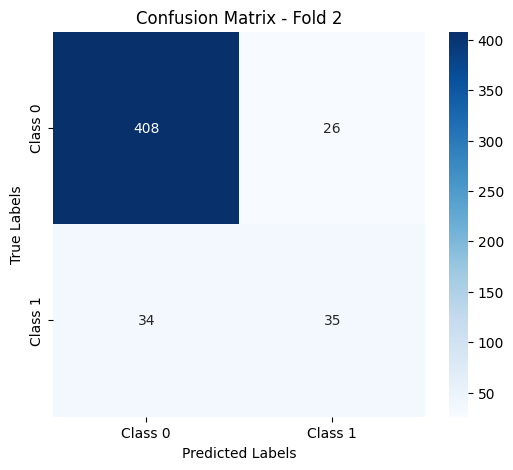

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5792, Val Loss: 0.4319, Train Acc: 0.7612, Val Acc: 0.8904
Epoch [2/50], Train Loss: 0.4835, Val Loss: 0.3604, Train Acc: 0.7767, Val Acc: 0.8944
Epoch [3/50], Train Loss: 0.4230, Val Loss: 0.3287, Train Acc: 0.8110, Val Acc: 0.8904
Epoch [4/50], Train Loss: 0.3780, Val Loss: 0.3095, Train Acc: 0.8471, Val Acc: 0.8725
Epoch [5/50], Train Loss: 0.3500, Val Loss: 0.2942, Train Acc: 0.8586, Val Acc: 0.8825
Epoch [6/50], Train Loss: 0.3270, Val Loss: 0.2776, Train Acc: 0.8656, Val Acc: 0.8984
Epoch [7/50], Train Loss: 0.3130, Val Loss: 0.2705, Train Acc: 0.8731, Val Acc: 0.9064
Epoch [8/50], Train Loss: 0.2999, Val Loss: 0.2635, Train Acc: 0.8775, Val Acc: 0.9104
Epoch [9/50], Train Loss: 0.2907, Val Loss: 0.2633, Train Acc: 0.8846, Val Acc: 0.9024
Epoch [10/50], Train Loss: 0.2839, Val Loss: 0.2682, Train Acc: 0.8872, Val Acc: 0.8964
Epoch [11/50], Train Loss: 0.2755, Val Loss: 0.2510, Train Acc: 0.8943, Val Acc: 0.9104
Epoch [12/50], Train Loss: 0.2682, Val Lo

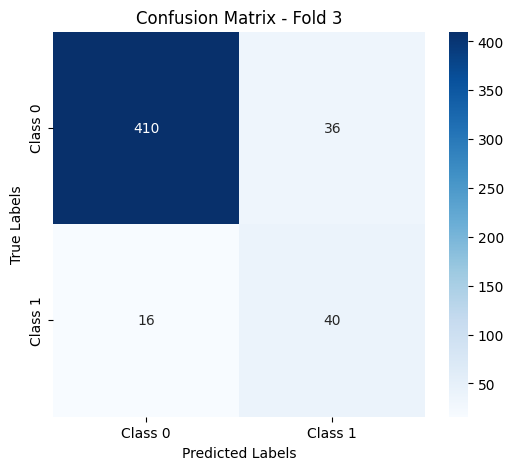

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5775, Val Loss: 0.4441, Train Acc: 0.7662, Val Acc: 0.8745
Epoch [2/50], Train Loss: 0.4731, Val Loss: 0.3675, Train Acc: 0.7777, Val Acc: 0.8725
Epoch [3/50], Train Loss: 0.4115, Val Loss: 0.3266, Train Acc: 0.8144, Val Acc: 0.8725
Epoch [4/50], Train Loss: 0.3682, Val Loss: 0.3165, Train Acc: 0.8542, Val Acc: 0.8665
Epoch [5/50], Train Loss: 0.3407, Val Loss: 0.3037, Train Acc: 0.8661, Val Acc: 0.8665
Epoch [6/50], Train Loss: 0.3208, Val Loss: 0.2971, Train Acc: 0.8749, Val Acc: 0.8625
Epoch [7/50], Train Loss: 0.3043, Val Loss: 0.2964, Train Acc: 0.8825, Val Acc: 0.8665
Epoch [8/50], Train Loss: 0.2915, Val Loss: 0.2997, Train Acc: 0.8909, Val Acc: 0.8566
Epoch [9/50], Train Loss: 0.2803, Val Loss: 0.2971, Train Acc: 0.8931, Val Acc: 0.8685
Epoch [10/50], Train Loss: 0.2707, Val Loss: 0.3001, Train Acc: 0.8962, Val Acc: 0.8625
Epoch [11/50], Train Loss: 0.2645, Val Loss: 0.2962, Train Acc: 0.9019, Val Acc: 0.8665
Epoch [12/50], Train Loss: 0.2601, Val Lo

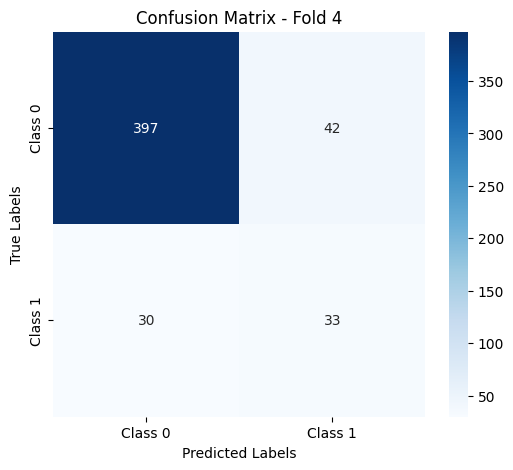

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5994, Val Loss: 0.4561, Train Acc: 0.7350, Val Acc: 0.8765
Epoch [2/50], Train Loss: 0.4815, Val Loss: 0.3734, Train Acc: 0.7822, Val Acc: 0.8765
Epoch [3/50], Train Loss: 0.4110, Val Loss: 0.3195, Train Acc: 0.8308, Val Acc: 0.8805
Epoch [4/50], Train Loss: 0.3651, Val Loss: 0.2902, Train Acc: 0.8573, Val Acc: 0.8865
Epoch [5/50], Train Loss: 0.3337, Val Loss: 0.2779, Train Acc: 0.8688, Val Acc: 0.8825
Epoch [6/50], Train Loss: 0.3153, Val Loss: 0.2719, Train Acc: 0.8785, Val Acc: 0.8745
Epoch [7/50], Train Loss: 0.2980, Val Loss: 0.2662, Train Acc: 0.8883, Val Acc: 0.8745
Epoch [8/50], Train Loss: 0.2886, Val Loss: 0.2628, Train Acc: 0.8918, Val Acc: 0.8805
Epoch [9/50], Train Loss: 0.2769, Val Loss: 0.2639, Train Acc: 0.8958, Val Acc: 0.8805
Epoch [10/50], Train Loss: 0.2708, Val Loss: 0.2615, Train Acc: 0.8971, Val Acc: 0.8845
Epoch [11/50], Train Loss: 0.2616, Val Loss: 0.2633, Train Acc: 0.9072, Val Acc: 0.8845
Epoch [12/50], Train Loss: 0.2552, Val Lo

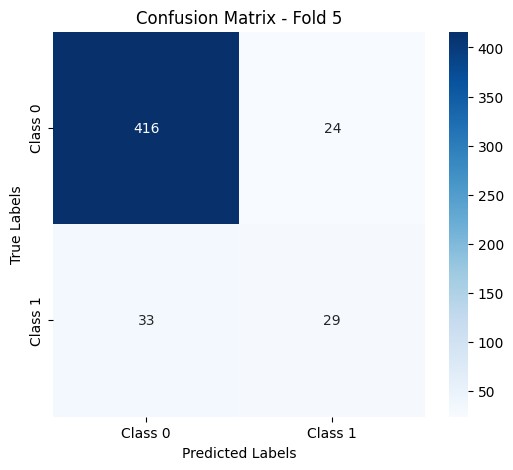


Average Validation Accuracy: 0.8822
Experiment 1 completed.

Running Experiment 2 with parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.3951, Val Loss: 0.2772, Train Acc: 0.8305, Val Acc: 0.8728
Epoch [2/50], Train Loss: 0.2931, Val Loss: 0.2467, Train Acc: 0.8761, Val Acc: 0.8986
Epoch [3/50], Train Loss: 0.2515, Val Loss: 0.2671, Train Acc: 0.9035, Val Acc: 0.8847
Epoch [4/50], Train Loss: 0.2250, Val Loss: 0.2584, Train Acc: 0.9097, Val Acc: 0.9006
Epoch [5/50], Train Loss: 0.1968, Val Loss: 0.3146, Train Acc: 0.9190, Val Acc: 0.8608
Epoch [6/50], Train Loss: 0.1758, Val Loss: 0.2931, Train Acc: 0.9296, Val Acc: 0.8847
Epoch [7/50], Train Loss: 0.1444, Val Loss: 0.3114, Train Acc: 0.9433, Val Acc: 0.8827
Epoch [8/50], Train Loss: 0.1254, Val Loss: 0.3442, Train Acc: 0.9553, Val Acc: 0.8926
Epoch [9/50], Train Loss: 0.1100, Val Loss: 0.3783, Train Acc: 0.9593, Val Acc: 0.8867
Epoch [10/50], Train Loss: 0.1065, Val Loss: 0.3472, Train Acc: 0.9610, Val Acc: 0.8907
Epoch [11/50], Train Loss: 0.0802, Val Loss: 0.3925, Train Acc: 0.9730, Val Acc: 0.8867
Epoch [12/50], Train Loss: 0.0771, Val Lo

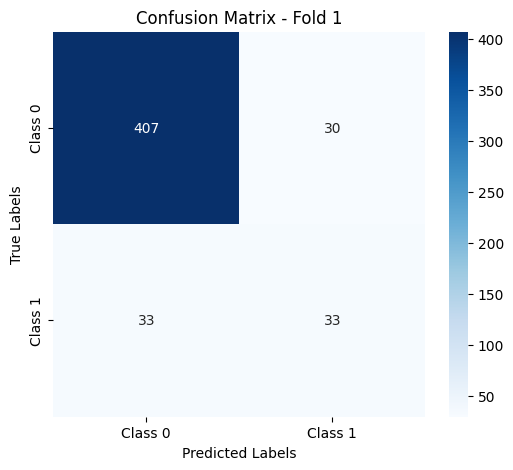

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.3907, Val Loss: 0.2558, Train Acc: 0.8245, Val Acc: 0.8807
Epoch [2/50], Train Loss: 0.2852, Val Loss: 0.2617, Train Acc: 0.8816, Val Acc: 0.8787
Epoch [3/50], Train Loss: 0.2448, Val Loss: 0.2553, Train Acc: 0.9038, Val Acc: 0.8847
Epoch [4/50], Train Loss: 0.2229, Val Loss: 0.3132, Train Acc: 0.9105, Val Acc: 0.8549
Epoch [5/50], Train Loss: 0.1872, Val Loss: 0.2906, Train Acc: 0.9273, Val Acc: 0.9006
Epoch [6/50], Train Loss: 0.1608, Val Loss: 0.3025, Train Acc: 0.9433, Val Acc: 0.8926
Epoch [7/50], Train Loss: 0.1423, Val Loss: 0.3271, Train Acc: 0.9499, Val Acc: 0.8926
Epoch [8/50], Train Loss: 0.1208, Val Loss: 0.3454, Train Acc: 0.9610, Val Acc: 0.8887
Epoch [9/50], Train Loss: 0.1101, Val Loss: 0.3957, Train Acc: 0.9632, Val Acc: 0.8807
Epoch [10/50], Train Loss: 0.1144, Val Loss: 0.3662, Train Acc: 0.9597, Val Acc: 0.8847
Epoch [11/50], Train Loss: 0.0939, Val Loss: 0.3838, Train Acc: 0.9681, Val Acc: 0.8847
Epoch [12/50], Train Loss: 0.0804, Val Lo

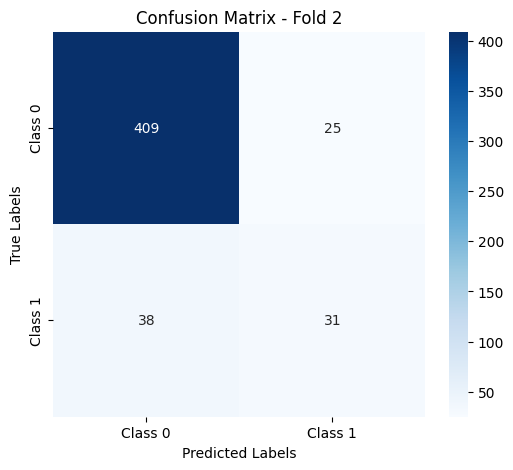

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.4093, Val Loss: 0.2682, Train Acc: 0.8137, Val Acc: 0.8805
Epoch [2/50], Train Loss: 0.2934, Val Loss: 0.2482, Train Acc: 0.8806, Val Acc: 0.8944
Epoch [3/50], Train Loss: 0.2506, Val Loss: 0.2341, Train Acc: 0.8996, Val Acc: 0.8984
Epoch [4/50], Train Loss: 0.2238, Val Loss: 0.2346, Train Acc: 0.9167, Val Acc: 0.9044
Epoch [5/50], Train Loss: 0.1966, Val Loss: 0.2491, Train Acc: 0.9278, Val Acc: 0.9084
Epoch [6/50], Train Loss: 0.1664, Val Loss: 0.2932, Train Acc: 0.9379, Val Acc: 0.8865
Epoch [7/50], Train Loss: 0.1561, Val Loss: 0.2730, Train Acc: 0.9454, Val Acc: 0.8984
Epoch [8/50], Train Loss: 0.1336, Val Loss: 0.3139, Train Acc: 0.9489, Val Acc: 0.8825
Epoch [9/50], Train Loss: 0.1141, Val Loss: 0.4112, Train Acc: 0.9573, Val Acc: 0.8586
Epoch [10/50], Train Loss: 0.1080, Val Loss: 0.3254, Train Acc: 0.9626, Val Acc: 0.9024
Epoch [11/50], Train Loss: 0.0869, Val Loss: 0.3263, Train Acc: 0.9727, Val Acc: 0.9084
Epoch [12/50], Train Loss: 0.0768, Val Lo

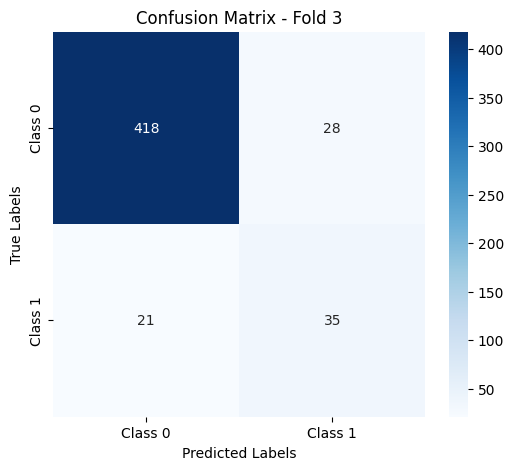

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.4041, Val Loss: 0.2907, Train Acc: 0.8246, Val Acc: 0.8785
Epoch [2/50], Train Loss: 0.2818, Val Loss: 0.3130, Train Acc: 0.8891, Val Acc: 0.8566
Epoch [3/50], Train Loss: 0.2403, Val Loss: 0.3157, Train Acc: 0.9054, Val Acc: 0.8606
Epoch [4/50], Train Loss: 0.2107, Val Loss: 0.3543, Train Acc: 0.9200, Val Acc: 0.8586
Epoch [5/50], Train Loss: 0.1919, Val Loss: 0.3372, Train Acc: 0.9311, Val Acc: 0.8566
Epoch [6/50], Train Loss: 0.1681, Val Loss: 0.3830, Train Acc: 0.9390, Val Acc: 0.8606
Epoch [7/50], Train Loss: 0.1353, Val Loss: 0.4430, Train Acc: 0.9505, Val Acc: 0.8606
Epoch [8/50], Train Loss: 0.1176, Val Loss: 0.4396, Train Acc: 0.9571, Val Acc: 0.8506
Epoch [9/50], Train Loss: 0.0958, Val Loss: 0.5032, Train Acc: 0.9664, Val Acc: 0.8466
Epoch [10/50], Train Loss: 0.0873, Val Loss: 0.5036, Train Acc: 0.9708, Val Acc: 0.8606
Epoch [11/50], Train Loss: 0.0776, Val Loss: 0.5399, Train Acc: 0.9748, Val Acc: 0.8466
Epoch [12/50], Train Loss: 0.0710, Val Lo

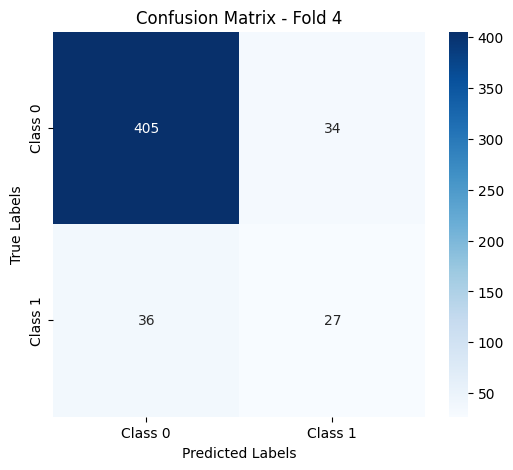

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.4045, Val Loss: 0.2999, Train Acc: 0.8198, Val Acc: 0.8546
Epoch [2/50], Train Loss: 0.2872, Val Loss: 0.2692, Train Acc: 0.8860, Val Acc: 0.8845
Epoch [3/50], Train Loss: 0.2568, Val Loss: 0.2567, Train Acc: 0.9011, Val Acc: 0.9004
Epoch [4/50], Train Loss: 0.2288, Val Loss: 0.2696, Train Acc: 0.9152, Val Acc: 0.8924
Epoch [5/50], Train Loss: 0.2026, Val Loss: 0.2991, Train Acc: 0.9280, Val Acc: 0.8924
Epoch [6/50], Train Loss: 0.1853, Val Loss: 0.3184, Train Acc: 0.9386, Val Acc: 0.8845
Epoch [7/50], Train Loss: 0.1702, Val Loss: 0.3218, Train Acc: 0.9413, Val Acc: 0.8785
Epoch [8/50], Train Loss: 0.1466, Val Loss: 0.3208, Train Acc: 0.9505, Val Acc: 0.8845
Epoch [9/50], Train Loss: 0.1227, Val Loss: 0.3620, Train Acc: 0.9576, Val Acc: 0.8884
Epoch [10/50], Train Loss: 0.1031, Val Loss: 0.3838, Train Acc: 0.9642, Val Acc: 0.8984
Epoch [11/50], Train Loss: 0.1024, Val Loss: 0.3998, Train Acc: 0.9629, Val Acc: 0.8825
Epoch [12/50], Train Loss: 0.0832, Val Lo

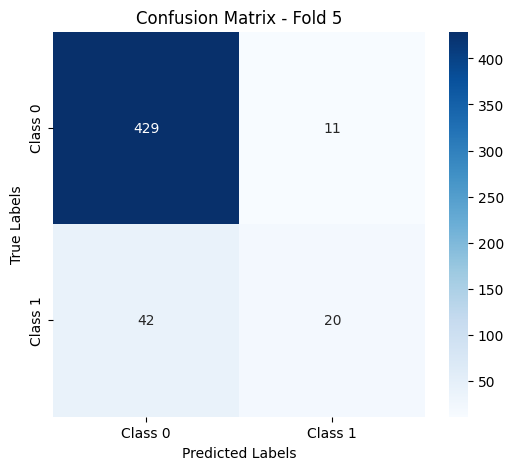


Average Validation Accuracy: 0.8814
Experiment 2 completed.

Running Experiment 3 with parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5803, Val Loss: 0.4850, Train Acc: 0.7769, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.5089, Val Loss: 0.4094, Train Acc: 0.7787, Val Acc: 0.8688
Epoch [3/50], Train Loss: 0.4598, Val Loss: 0.3651, Train Acc: 0.7791, Val Acc: 0.8748
Epoch [4/50], Train Loss: 0.4164, Val Loss: 0.3330, Train Acc: 0.8012, Val Acc: 0.9006
Epoch [5/50], Train Loss: 0.3795, Val Loss: 0.3089, Train Acc: 0.8344, Val Acc: 0.8887
Epoch [6/50], Train Loss: 0.3548, Val Loss: 0.2956, Train Acc: 0.8561, Val Acc: 0.8767
Epoch [7/50], Train Loss: 0.3336, Val Loss: 0.2867, Train Acc: 0.8645, Val Acc: 0.8767
Epoch [8/50], Train Loss: 0.3198, Val Loss: 0.2817, Train Acc: 0.8703, Val Acc: 0.8787
Epoch [9/50], Train Loss: 0.3052, Val Loss: 0.2822, Train Acc: 0.8756, Val Acc: 0.8787
Epoch [10/50], Train Loss: 0.2937, Val Loss: 0.2755, Train Acc: 0.8809, Val Acc: 0.8807
Epoch [11/50], Train Loss: 0.2862, Val Loss: 0.2790, Train Acc: 0.8805, Val Acc: 0.8748
Epoch [12/50], Train Loss: 0.2801, Val Lo

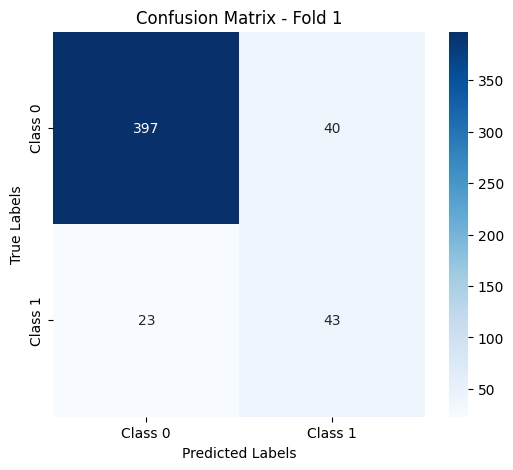

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6104, Val Loss: 0.5074, Train Acc: 0.7287, Val Acc: 0.8628
Epoch [2/50], Train Loss: 0.5138, Val Loss: 0.4189, Train Acc: 0.7824, Val Acc: 0.8628
Epoch [3/50], Train Loss: 0.4598, Val Loss: 0.3695, Train Acc: 0.7868, Val Acc: 0.8688
Epoch [4/50], Train Loss: 0.4149, Val Loss: 0.3389, Train Acc: 0.8054, Val Acc: 0.8867
Epoch [5/50], Train Loss: 0.3794, Val Loss: 0.3180, Train Acc: 0.8422, Val Acc: 0.8907
Epoch [6/50], Train Loss: 0.3533, Val Loss: 0.2993, Train Acc: 0.8537, Val Acc: 0.8946
Epoch [7/50], Train Loss: 0.3354, Val Loss: 0.2917, Train Acc: 0.8626, Val Acc: 0.8847
Epoch [8/50], Train Loss: 0.3173, Val Loss: 0.2865, Train Acc: 0.8728, Val Acc: 0.8847
Epoch [9/50], Train Loss: 0.3095, Val Loss: 0.2820, Train Acc: 0.8759, Val Acc: 0.8847
Epoch [10/50], Train Loss: 0.2992, Val Loss: 0.2772, Train Acc: 0.8808, Val Acc: 0.8887
Epoch [11/50], Train Loss: 0.2939, Val Loss: 0.2740, Train Acc: 0.8799, Val Acc: 0.8847
Epoch [12/50], Train Loss: 0.2856, Val Lo

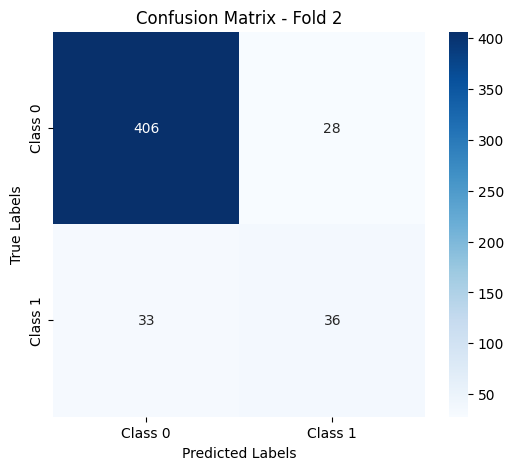

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5940, Val Loss: 0.4705, Train Acc: 0.7656, Val Acc: 0.8884
Epoch [2/50], Train Loss: 0.5203, Val Loss: 0.3923, Train Acc: 0.7709, Val Acc: 0.8884
Epoch [3/50], Train Loss: 0.4715, Val Loss: 0.3491, Train Acc: 0.7731, Val Acc: 0.8964
Epoch [4/50], Train Loss: 0.4316, Val Loss: 0.3214, Train Acc: 0.7872, Val Acc: 0.9024
Epoch [5/50], Train Loss: 0.3985, Val Loss: 0.3000, Train Acc: 0.8167, Val Acc: 0.9064
Epoch [6/50], Train Loss: 0.3739, Val Loss: 0.2862, Train Acc: 0.8432, Val Acc: 0.9044
Epoch [7/50], Train Loss: 0.3529, Val Loss: 0.2776, Train Acc: 0.8564, Val Acc: 0.8904
Epoch [8/50], Train Loss: 0.3405, Val Loss: 0.2735, Train Acc: 0.8634, Val Acc: 0.8845
Epoch [9/50], Train Loss: 0.3285, Val Loss: 0.2626, Train Acc: 0.8665, Val Acc: 0.8865
Epoch [10/50], Train Loss: 0.3177, Val Loss: 0.2635, Train Acc: 0.8775, Val Acc: 0.8825
Epoch [11/50], Train Loss: 0.3078, Val Loss: 0.2579, Train Acc: 0.8767, Val Acc: 0.8865
Epoch [12/50], Train Loss: 0.2981, Val Lo

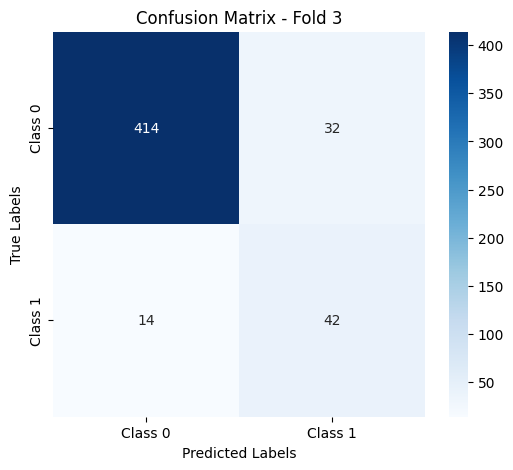

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6453, Val Loss: 0.5489, Train Acc: 0.6757, Val Acc: 0.8685
Epoch [2/50], Train Loss: 0.5436, Val Loss: 0.4511, Train Acc: 0.7892, Val Acc: 0.8705
Epoch [3/50], Train Loss: 0.4821, Val Loss: 0.3978, Train Acc: 0.7919, Val Acc: 0.8765
Epoch [4/50], Train Loss: 0.4336, Val Loss: 0.3616, Train Acc: 0.8188, Val Acc: 0.8765
Epoch [5/50], Train Loss: 0.3912, Val Loss: 0.3382, Train Acc: 0.8431, Val Acc: 0.8825
Epoch [6/50], Train Loss: 0.3600, Val Loss: 0.3204, Train Acc: 0.8621, Val Acc: 0.8745
Epoch [7/50], Train Loss: 0.3359, Val Loss: 0.3134, Train Acc: 0.8754, Val Acc: 0.8825
Epoch [8/50], Train Loss: 0.3178, Val Loss: 0.3053, Train Acc: 0.8860, Val Acc: 0.8785
Epoch [9/50], Train Loss: 0.3074, Val Loss: 0.3001, Train Acc: 0.8851, Val Acc: 0.8805
Epoch [10/50], Train Loss: 0.2942, Val Loss: 0.2963, Train Acc: 0.8935, Val Acc: 0.8845
Epoch [11/50], Train Loss: 0.2867, Val Loss: 0.2929, Train Acc: 0.8957, Val Acc: 0.8805
Epoch [12/50], Train Loss: 0.2785, Val Lo

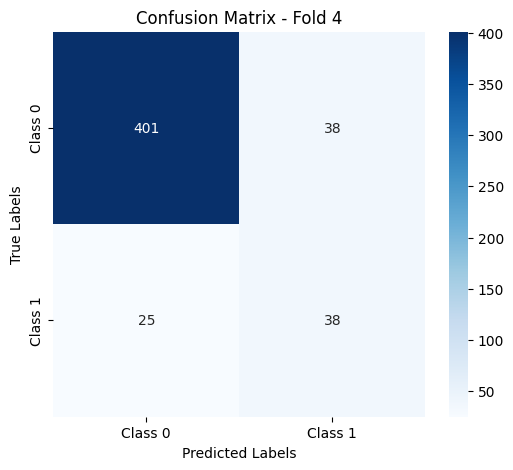

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6267, Val Loss: 0.5242, Train Acc: 0.7032, Val Acc: 0.8725
Epoch [2/50], Train Loss: 0.5308, Val Loss: 0.4290, Train Acc: 0.7796, Val Acc: 0.8765
Epoch [3/50], Train Loss: 0.4749, Val Loss: 0.3799, Train Acc: 0.7831, Val Acc: 0.8805
Epoch [4/50], Train Loss: 0.4338, Val Loss: 0.3506, Train Acc: 0.8101, Val Acc: 0.8765
Epoch [5/50], Train Loss: 0.3986, Val Loss: 0.3286, Train Acc: 0.8401, Val Acc: 0.8765
Epoch [6/50], Train Loss: 0.3720, Val Loss: 0.3146, Train Acc: 0.8534, Val Acc: 0.8725
Epoch [7/50], Train Loss: 0.3504, Val Loss: 0.3074, Train Acc: 0.8617, Val Acc: 0.8665
Epoch [8/50], Train Loss: 0.3361, Val Loss: 0.3018, Train Acc: 0.8644, Val Acc: 0.8586
Epoch [9/50], Train Loss: 0.3212, Val Loss: 0.2964, Train Acc: 0.8763, Val Acc: 0.8566
Epoch [10/50], Train Loss: 0.3102, Val Loss: 0.2931, Train Acc: 0.8816, Val Acc: 0.8606
Epoch [11/50], Train Loss: 0.3027, Val Loss: 0.2923, Train Acc: 0.8852, Val Acc: 0.8685
Epoch [12/50], Train Loss: 0.2915, Val Lo

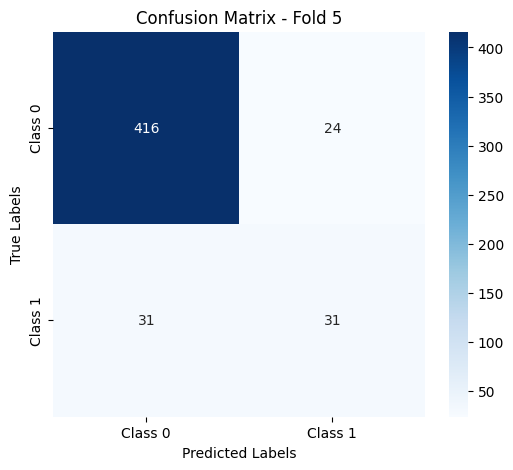


Average Validation Accuracy: 0.8854
Experiment 3 completed.

Running Experiment 4 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 256, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5552, Val Loss: 0.3574, Train Acc: 0.7047, Val Acc: 0.8807
Epoch [2/50], Train Loss: 0.3886, Val Loss: 0.2977, Train Acc: 0.8322, Val Acc: 0.8946
Epoch [3/50], Train Loss: 0.3269, Val Loss: 0.2692, Train Acc: 0.8641, Val Acc: 0.8986
Epoch [4/50], Train Loss: 0.2997, Val Loss: 0.2565, Train Acc: 0.8792, Val Acc: 0.8986
Epoch [5/50], Train Loss: 0.2796, Val Loss: 0.2429, Train Acc: 0.8880, Val Acc: 0.9006
Epoch [6/50], Train Loss: 0.2659, Val Loss: 0.2596, Train Acc: 0.8973, Val Acc: 0.8946
Epoch [7/50], Train Loss: 0.2464, Val Loss: 0.2589, Train Acc: 0.9070, Val Acc: 0.8986
Epoch [8/50], Train Loss: 0.2345, Val Loss: 0.2484, Train Acc: 0.9159, Val Acc: 0.8986
Epoch [9/50], Train Loss: 0.2245, Val Loss: 0.2528, Train Acc: 0.9216, Val Acc: 0.9006
Epoch [10/50], Train Loss: 0.2166, Val Loss: 0.2646, Train Acc: 0.9190, Val Acc: 0.8966
Epoch [11/50], Train Loss: 0.1996, Val Loss: 0.2664, Train Acc: 0.9256, Val Acc: 0.8966
Epoch [12/50], Train Loss: 0.1858, Val Lo

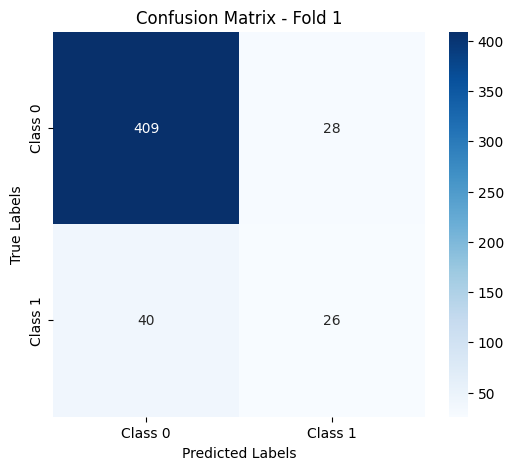

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5237, Val Loss: 0.3495, Train Acc: 0.7571, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.3767, Val Loss: 0.2866, Train Acc: 0.8400, Val Acc: 0.8767
Epoch [3/50], Train Loss: 0.3193, Val Loss: 0.2626, Train Acc: 0.8706, Val Acc: 0.8887
Epoch [4/50], Train Loss: 0.2876, Val Loss: 0.2724, Train Acc: 0.8808, Val Acc: 0.8767
Epoch [5/50], Train Loss: 0.2712, Val Loss: 0.2624, Train Acc: 0.8958, Val Acc: 0.8847
Epoch [6/50], Train Loss: 0.2586, Val Loss: 0.2616, Train Acc: 0.9007, Val Acc: 0.8867
Epoch [7/50], Train Loss: 0.2455, Val Loss: 0.2789, Train Acc: 0.9038, Val Acc: 0.8668
Epoch [8/50], Train Loss: 0.2332, Val Loss: 0.2669, Train Acc: 0.9109, Val Acc: 0.8787
Epoch [9/50], Train Loss: 0.2231, Val Loss: 0.2737, Train Acc: 0.9127, Val Acc: 0.8748
Epoch [10/50], Train Loss: 0.2132, Val Loss: 0.2723, Train Acc: 0.9211, Val Acc: 0.8807
Epoch [11/50], Train Loss: 0.2053, Val Loss: 0.2790, Train Acc: 0.9242, Val Acc: 0.8748
Epoch [12/50], Train Loss: 0.1953, Val Lo

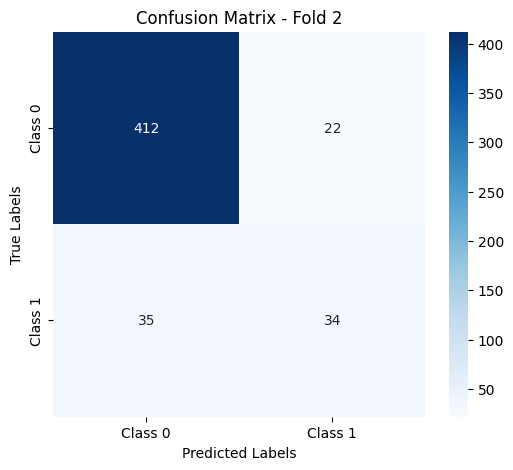

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5325, Val Loss: 0.3274, Train Acc: 0.7533, Val Acc: 0.8904
Epoch [2/50], Train Loss: 0.3849, Val Loss: 0.2804, Train Acc: 0.8260, Val Acc: 0.8984
Epoch [3/50], Train Loss: 0.3191, Val Loss: 0.2581, Train Acc: 0.8665, Val Acc: 0.8944
Epoch [4/50], Train Loss: 0.2866, Val Loss: 0.2579, Train Acc: 0.8824, Val Acc: 0.8884
Epoch [5/50], Train Loss: 0.2722, Val Loss: 0.2565, Train Acc: 0.8912, Val Acc: 0.8924
Epoch [6/50], Train Loss: 0.2532, Val Loss: 0.2519, Train Acc: 0.9084, Val Acc: 0.8964
Epoch [7/50], Train Loss: 0.2466, Val Loss: 0.2396, Train Acc: 0.9079, Val Acc: 0.9044
Epoch [8/50], Train Loss: 0.2296, Val Loss: 0.2536, Train Acc: 0.9181, Val Acc: 0.8984
Epoch [9/50], Train Loss: 0.2200, Val Loss: 0.2453, Train Acc: 0.9194, Val Acc: 0.8984
Epoch [10/50], Train Loss: 0.2085, Val Loss: 0.2576, Train Acc: 0.9247, Val Acc: 0.8944
Epoch [11/50], Train Loss: 0.2006, Val Loss: 0.2558, Train Acc: 0.9273, Val Acc: 0.8924
Epoch [12/50], Train Loss: 0.1914, Val Lo

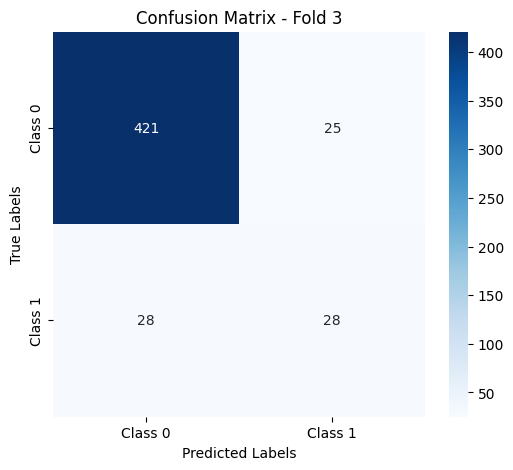

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5362, Val Loss: 0.3721, Train Acc: 0.7459, Val Acc: 0.8805
Epoch [2/50], Train Loss: 0.3765, Val Loss: 0.3093, Train Acc: 0.8330, Val Acc: 0.8745
Epoch [3/50], Train Loss: 0.3090, Val Loss: 0.2914, Train Acc: 0.8719, Val Acc: 0.8825
Epoch [4/50], Train Loss: 0.2728, Val Loss: 0.2793, Train Acc: 0.8873, Val Acc: 0.8904
Epoch [5/50], Train Loss: 0.2500, Val Loss: 0.2965, Train Acc: 0.9046, Val Acc: 0.8785
Epoch [6/50], Train Loss: 0.2383, Val Loss: 0.2986, Train Acc: 0.9081, Val Acc: 0.8785
Epoch [7/50], Train Loss: 0.2247, Val Loss: 0.3033, Train Acc: 0.9143, Val Acc: 0.8725
Epoch [8/50], Train Loss: 0.2078, Val Loss: 0.3283, Train Acc: 0.9249, Val Acc: 0.8566
Epoch [9/50], Train Loss: 0.2012, Val Loss: 0.3187, Train Acc: 0.9280, Val Acc: 0.8606
Epoch [10/50], Train Loss: 0.1910, Val Loss: 0.3228, Train Acc: 0.9311, Val Acc: 0.8645
Epoch [11/50], Train Loss: 0.1819, Val Loss: 0.3238, Train Acc: 0.9359, Val Acc: 0.8645
Epoch [12/50], Train Loss: 0.1682, Val Lo

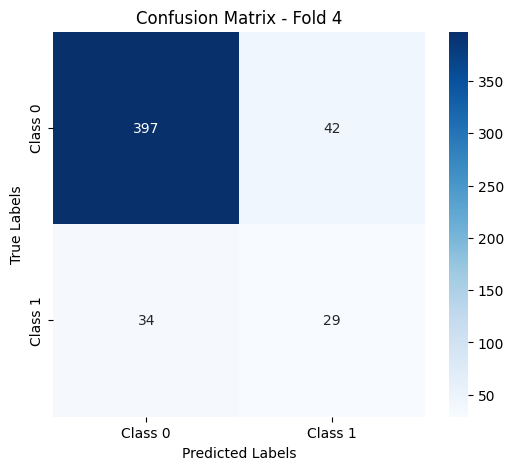

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5516, Val Loss: 0.3585, Train Acc: 0.7341, Val Acc: 0.8825
Epoch [2/50], Train Loss: 0.3829, Val Loss: 0.2725, Train Acc: 0.8414, Val Acc: 0.8984
Epoch [3/50], Train Loss: 0.3234, Val Loss: 0.2628, Train Acc: 0.8777, Val Acc: 0.8904
Epoch [4/50], Train Loss: 0.2937, Val Loss: 0.2543, Train Acc: 0.8834, Val Acc: 0.8884
Epoch [5/50], Train Loss: 0.2725, Val Loss: 0.2599, Train Acc: 0.8922, Val Acc: 0.8904
Epoch [6/50], Train Loss: 0.2595, Val Loss: 0.2643, Train Acc: 0.9037, Val Acc: 0.8845
Epoch [7/50], Train Loss: 0.2509, Val Loss: 0.2596, Train Acc: 0.9077, Val Acc: 0.8984
Epoch [8/50], Train Loss: 0.2365, Val Loss: 0.2640, Train Acc: 0.9139, Val Acc: 0.8964
Epoch [9/50], Train Loss: 0.2261, Val Loss: 0.2856, Train Acc: 0.9231, Val Acc: 0.8765
Epoch [10/50], Train Loss: 0.2156, Val Loss: 0.2711, Train Acc: 0.9298, Val Acc: 0.8964
Epoch [11/50], Train Loss: 0.2119, Val Loss: 0.2696, Train Acc: 0.9284, Val Acc: 0.8924
Epoch [12/50], Train Loss: 0.1993, Val Lo

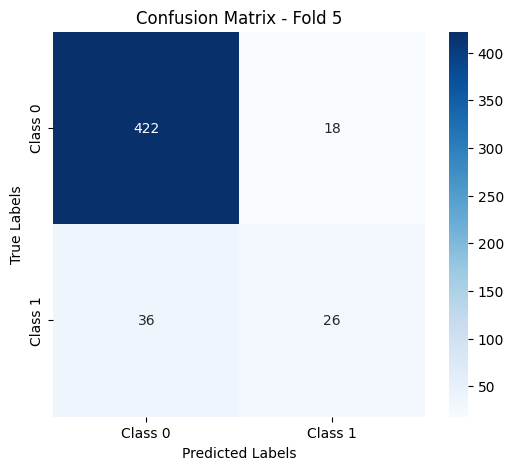


Average Validation Accuracy: 0.8774
Experiment 4 completed.

Running Experiment 5 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 4, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5663, Val Loss: 0.4273, Train Acc: 0.7685, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.4710, Val Loss: 0.3581, Train Acc: 0.7800, Val Acc: 0.8767
Epoch [3/50], Train Loss: 0.4144, Val Loss: 0.3155, Train Acc: 0.8119, Val Acc: 0.8907
Epoch [4/50], Train Loss: 0.3716, Val Loss: 0.2908, Train Acc: 0.8477, Val Acc: 0.8887
Epoch [5/50], Train Loss: 0.3425, Val Loss: 0.2719, Train Acc: 0.8637, Val Acc: 0.9006
Epoch [6/50], Train Loss: 0.3221, Val Loss: 0.2675, Train Acc: 0.8703, Val Acc: 0.8907
Epoch [7/50], Train Loss: 0.3038, Val Loss: 0.2629, Train Acc: 0.8831, Val Acc: 0.8907
Epoch [8/50], Train Loss: 0.2943, Val Loss: 0.2689, Train Acc: 0.8898, Val Acc: 0.8867
Epoch [9/50], Train Loss: 0.2814, Val Loss: 0.2639, Train Acc: 0.8920, Val Acc: 0.8847
Epoch [10/50], Train Loss: 0.2725, Val Loss: 0.2667, Train Acc: 0.8920, Val Acc: 0.8827
Epoch [11/50], Train Loss: 0.2627, Val Loss: 0.2669, Train Acc: 0.9008, Val Acc: 0.8827
Epoch [12/50], Train Loss: 0.2543, Val Lo

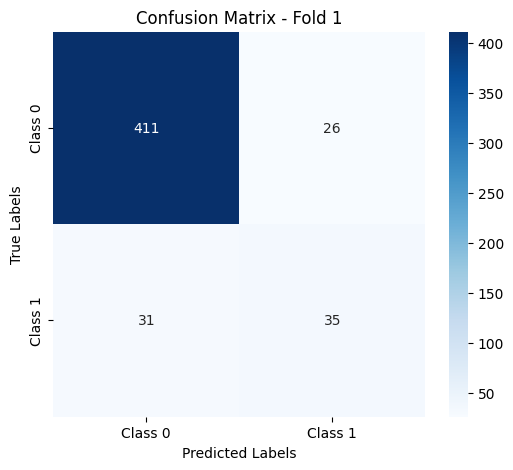

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6061, Val Loss: 0.4667, Train Acc: 0.7123, Val Acc: 0.8628
Epoch [2/50], Train Loss: 0.4840, Val Loss: 0.3760, Train Acc: 0.7815, Val Acc: 0.8688
Epoch [3/50], Train Loss: 0.4171, Val Loss: 0.3272, Train Acc: 0.8081, Val Acc: 0.8807
Epoch [4/50], Train Loss: 0.3648, Val Loss: 0.2974, Train Acc: 0.8528, Val Acc: 0.8847
Epoch [5/50], Train Loss: 0.3353, Val Loss: 0.2806, Train Acc: 0.8692, Val Acc: 0.8827
Epoch [6/50], Train Loss: 0.3191, Val Loss: 0.2787, Train Acc: 0.8723, Val Acc: 0.8748
Epoch [7/50], Train Loss: 0.3070, Val Loss: 0.2710, Train Acc: 0.8777, Val Acc: 0.8648
Epoch [8/50], Train Loss: 0.2940, Val Loss: 0.2663, Train Acc: 0.8852, Val Acc: 0.8767
Epoch [9/50], Train Loss: 0.2879, Val Loss: 0.2680, Train Acc: 0.8834, Val Acc: 0.8807
Epoch [10/50], Train Loss: 0.2755, Val Loss: 0.2650, Train Acc: 0.8936, Val Acc: 0.8787
Epoch [11/50], Train Loss: 0.2719, Val Loss: 0.2631, Train Acc: 0.8936, Val Acc: 0.8847
Epoch [12/50], Train Loss: 0.2610, Val Lo

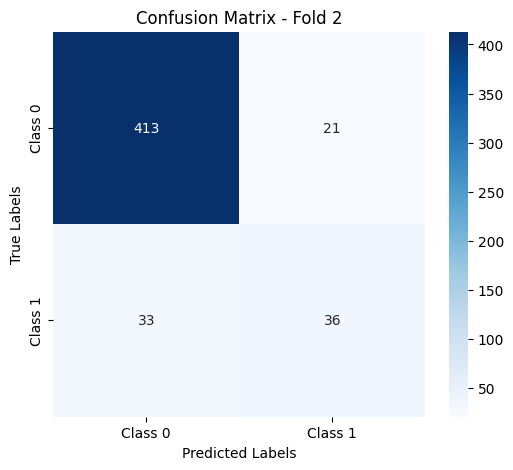

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6069, Val Loss: 0.4480, Train Acc: 0.7256, Val Acc: 0.8865
Epoch [2/50], Train Loss: 0.4969, Val Loss: 0.3650, Train Acc: 0.7722, Val Acc: 0.8944
Epoch [3/50], Train Loss: 0.4391, Val Loss: 0.3261, Train Acc: 0.7960, Val Acc: 0.8944
Epoch [4/50], Train Loss: 0.3952, Val Loss: 0.2991, Train Acc: 0.8370, Val Acc: 0.8865
Epoch [5/50], Train Loss: 0.3633, Val Loss: 0.2934, Train Acc: 0.8590, Val Acc: 0.8705
Epoch [6/50], Train Loss: 0.3426, Val Loss: 0.2767, Train Acc: 0.8696, Val Acc: 0.8825
Epoch [7/50], Train Loss: 0.3274, Val Loss: 0.2740, Train Acc: 0.8648, Val Acc: 0.8865
Epoch [8/50], Train Loss: 0.3120, Val Loss: 0.2691, Train Acc: 0.8740, Val Acc: 0.8865
Epoch [9/50], Train Loss: 0.3021, Val Loss: 0.2609, Train Acc: 0.8789, Val Acc: 0.8904
Epoch [10/50], Train Loss: 0.2939, Val Loss: 0.2574, Train Acc: 0.8837, Val Acc: 0.8904
Epoch [11/50], Train Loss: 0.2801, Val Loss: 0.2514, Train Acc: 0.8890, Val Acc: 0.8944
Epoch [12/50], Train Loss: 0.2731, Val Lo

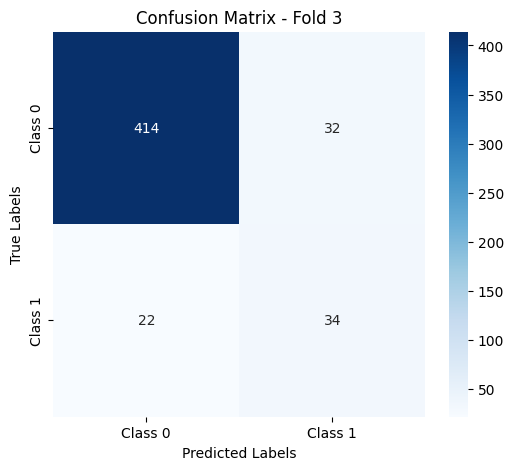

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5978, Val Loss: 0.4625, Train Acc: 0.7327, Val Acc: 0.8705
Epoch [2/50], Train Loss: 0.4782, Val Loss: 0.3762, Train Acc: 0.7844, Val Acc: 0.8725
Epoch [3/50], Train Loss: 0.4055, Val Loss: 0.3337, Train Acc: 0.8232, Val Acc: 0.8765
Epoch [4/50], Train Loss: 0.3577, Val Loss: 0.3090, Train Acc: 0.8564, Val Acc: 0.8845
Epoch [5/50], Train Loss: 0.3288, Val Loss: 0.2997, Train Acc: 0.8741, Val Acc: 0.8825
Epoch [6/50], Train Loss: 0.3099, Val Loss: 0.2946, Train Acc: 0.8776, Val Acc: 0.8884
Epoch [7/50], Train Loss: 0.2936, Val Loss: 0.2921, Train Acc: 0.8856, Val Acc: 0.8865
Epoch [8/50], Train Loss: 0.2838, Val Loss: 0.2941, Train Acc: 0.8886, Val Acc: 0.8785
Epoch [9/50], Train Loss: 0.2712, Val Loss: 0.2947, Train Acc: 0.9001, Val Acc: 0.8785
Epoch [10/50], Train Loss: 0.2615, Val Loss: 0.2978, Train Acc: 0.8979, Val Acc: 0.8705
Epoch [11/50], Train Loss: 0.2534, Val Loss: 0.2943, Train Acc: 0.9068, Val Acc: 0.8745
Epoch [12/50], Train Loss: 0.2462, Val Lo

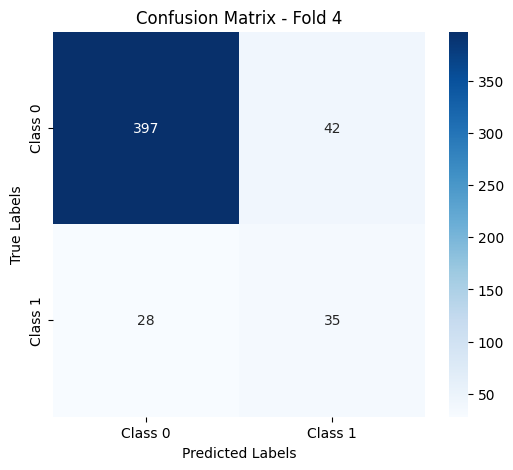

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6347, Val Loss: 0.4941, Train Acc: 0.6674, Val Acc: 0.8785
Epoch [2/50], Train Loss: 0.5175, Val Loss: 0.4024, Train Acc: 0.7756, Val Acc: 0.8785
Epoch [3/50], Train Loss: 0.4493, Val Loss: 0.3508, Train Acc: 0.7973, Val Acc: 0.8845
Epoch [4/50], Train Loss: 0.3910, Val Loss: 0.3167, Train Acc: 0.8485, Val Acc: 0.8825
Epoch [5/50], Train Loss: 0.3550, Val Loss: 0.2987, Train Acc: 0.8622, Val Acc: 0.8845
Epoch [6/50], Train Loss: 0.3339, Val Loss: 0.2822, Train Acc: 0.8737, Val Acc: 0.8904
Epoch [7/50], Train Loss: 0.3145, Val Loss: 0.2758, Train Acc: 0.8847, Val Acc: 0.8944
Epoch [8/50], Train Loss: 0.2993, Val Loss: 0.2706, Train Acc: 0.8927, Val Acc: 0.8904
Epoch [9/50], Train Loss: 0.2892, Val Loss: 0.2723, Train Acc: 0.8936, Val Acc: 0.8904
Epoch [10/50], Train Loss: 0.2825, Val Loss: 0.2680, Train Acc: 0.8980, Val Acc: 0.8904
Epoch [11/50], Train Loss: 0.2751, Val Loss: 0.2686, Train Acc: 0.9002, Val Acc: 0.8865
Epoch [12/50], Train Loss: 0.2675, Val Lo

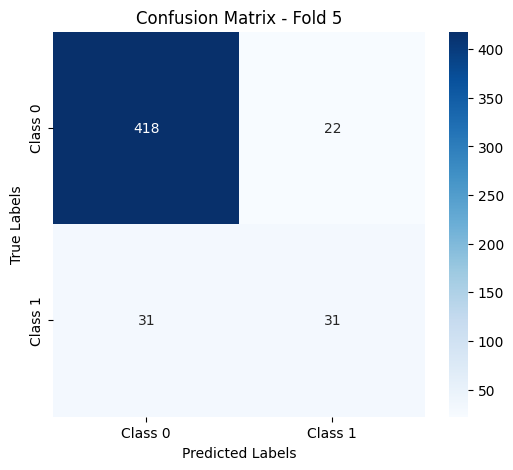


Average Validation Accuracy: 0.8853
Experiment 5 completed.

Running Experiment 6 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 6, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5923, Val Loss: 0.4299, Train Acc: 0.7229, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.4546, Val Loss: 0.3442, Train Acc: 0.7955, Val Acc: 0.8708
Epoch [3/50], Train Loss: 0.3847, Val Loss: 0.3131, Train Acc: 0.8389, Val Acc: 0.8648
Epoch [4/50], Train Loss: 0.3451, Val Loss: 0.2875, Train Acc: 0.8588, Val Acc: 0.8748
Epoch [5/50], Train Loss: 0.3264, Val Loss: 0.2815, Train Acc: 0.8703, Val Acc: 0.8728
Epoch [6/50], Train Loss: 0.3086, Val Loss: 0.2720, Train Acc: 0.8800, Val Acc: 0.8926
Epoch [7/50], Train Loss: 0.2952, Val Loss: 0.2837, Train Acc: 0.8853, Val Acc: 0.8748
Epoch [8/50], Train Loss: 0.2828, Val Loss: 0.2769, Train Acc: 0.8911, Val Acc: 0.8787
Epoch [9/50], Train Loss: 0.2762, Val Loss: 0.2622, Train Acc: 0.8969, Val Acc: 0.8926
Epoch [10/50], Train Loss: 0.2694, Val Loss: 0.2695, Train Acc: 0.8986, Val Acc: 0.8887
Epoch [11/50], Train Loss: 0.2590, Val Loss: 0.2636, Train Acc: 0.9026, Val Acc: 0.8907
Epoch [12/50], Train Loss: 0.2498, Val Lo

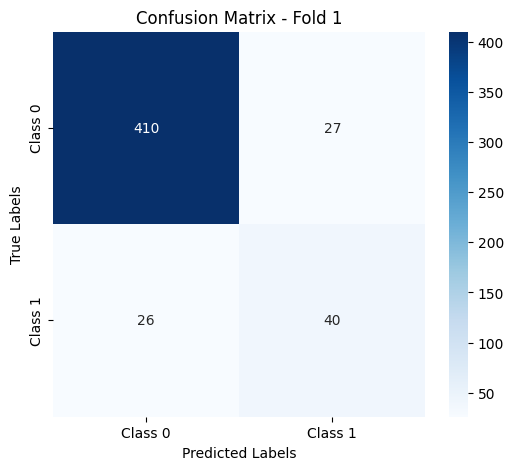

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5458, Val Loss: 0.4025, Train Acc: 0.7668, Val Acc: 0.8648
Epoch [2/50], Train Loss: 0.4431, Val Loss: 0.3355, Train Acc: 0.7965, Val Acc: 0.8787
Epoch [3/50], Train Loss: 0.3800, Val Loss: 0.3016, Train Acc: 0.8449, Val Acc: 0.8787
Epoch [4/50], Train Loss: 0.3429, Val Loss: 0.2848, Train Acc: 0.8644, Val Acc: 0.8748
Epoch [5/50], Train Loss: 0.3150, Val Loss: 0.2777, Train Acc: 0.8759, Val Acc: 0.8807
Epoch [6/50], Train Loss: 0.2971, Val Loss: 0.2781, Train Acc: 0.8861, Val Acc: 0.8748
Epoch [7/50], Train Loss: 0.2845, Val Loss: 0.2721, Train Acc: 0.8856, Val Acc: 0.8787
Epoch [8/50], Train Loss: 0.2715, Val Loss: 0.2699, Train Acc: 0.8936, Val Acc: 0.8787
Epoch [9/50], Train Loss: 0.2630, Val Loss: 0.2721, Train Acc: 0.8989, Val Acc: 0.8767
Epoch [10/50], Train Loss: 0.2575, Val Loss: 0.2663, Train Acc: 0.9038, Val Acc: 0.8807
Epoch [11/50], Train Loss: 0.2432, Val Loss: 0.2677, Train Acc: 0.9105, Val Acc: 0.8807
Epoch [12/50], Train Loss: 0.2365, Val Lo

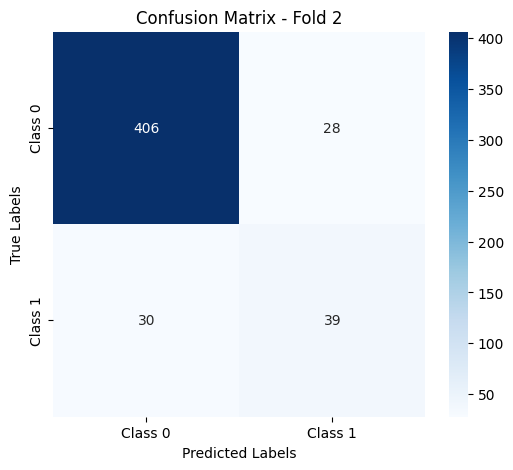

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5916, Val Loss: 0.4139, Train Acc: 0.7057, Val Acc: 0.8884
Epoch [2/50], Train Loss: 0.4810, Val Loss: 0.3507, Train Acc: 0.7806, Val Acc: 0.8805
Epoch [3/50], Train Loss: 0.4078, Val Loss: 0.3047, Train Acc: 0.8247, Val Acc: 0.8924
Epoch [4/50], Train Loss: 0.3562, Val Loss: 0.2905, Train Acc: 0.8573, Val Acc: 0.8845
Epoch [5/50], Train Loss: 0.3268, Val Loss: 0.2854, Train Acc: 0.8718, Val Acc: 0.8745
Epoch [6/50], Train Loss: 0.3072, Val Loss: 0.2603, Train Acc: 0.8780, Val Acc: 0.8845
Epoch [7/50], Train Loss: 0.2980, Val Loss: 0.2592, Train Acc: 0.8846, Val Acc: 0.8904
Epoch [8/50], Train Loss: 0.2873, Val Loss: 0.2633, Train Acc: 0.8890, Val Acc: 0.8845
Epoch [9/50], Train Loss: 0.2708, Val Loss: 0.2539, Train Acc: 0.9013, Val Acc: 0.8944
Epoch [10/50], Train Loss: 0.2634, Val Loss: 0.2595, Train Acc: 0.9013, Val Acc: 0.8845
Epoch [11/50], Train Loss: 0.2554, Val Loss: 0.2632, Train Acc: 0.9062, Val Acc: 0.8805
Epoch [12/50], Train Loss: 0.2425, Val Lo

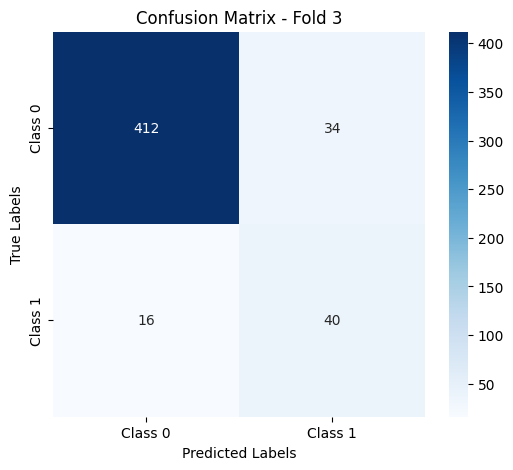

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5703, Val Loss: 0.4228, Train Acc: 0.7366, Val Acc: 0.8625
Epoch [2/50], Train Loss: 0.4373, Val Loss: 0.3693, Train Acc: 0.8131, Val Acc: 0.8546
Epoch [3/50], Train Loss: 0.3701, Val Loss: 0.3362, Train Acc: 0.8529, Val Acc: 0.8665
Epoch [4/50], Train Loss: 0.3321, Val Loss: 0.3388, Train Acc: 0.8657, Val Acc: 0.8546
Epoch [5/50], Train Loss: 0.3110, Val Loss: 0.3261, Train Acc: 0.8749, Val Acc: 0.8606
Epoch [6/50], Train Loss: 0.2882, Val Loss: 0.3351, Train Acc: 0.8833, Val Acc: 0.8466
Epoch [7/50], Train Loss: 0.2789, Val Loss: 0.3262, Train Acc: 0.8878, Val Acc: 0.8586
Epoch [8/50], Train Loss: 0.2702, Val Loss: 0.3264, Train Acc: 0.8931, Val Acc: 0.8526
Epoch [9/50], Train Loss: 0.2562, Val Loss: 0.3204, Train Acc: 0.9023, Val Acc: 0.8586
Epoch [10/50], Train Loss: 0.2490, Val Loss: 0.3239, Train Acc: 0.9037, Val Acc: 0.8566
Epoch [11/50], Train Loss: 0.2332, Val Loss: 0.3226, Train Acc: 0.9147, Val Acc: 0.8586
Epoch [12/50], Train Loss: 0.2277, Val Lo

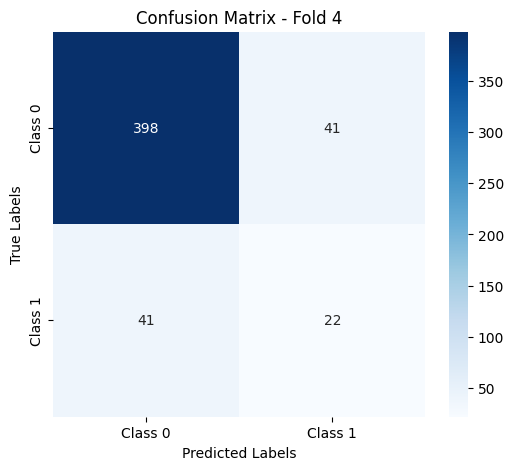

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6045, Val Loss: 0.4581, Train Acc: 0.7288, Val Acc: 0.8765
Epoch [2/50], Train Loss: 0.4782, Val Loss: 0.3759, Train Acc: 0.8017, Val Acc: 0.8825
Epoch [3/50], Train Loss: 0.4057, Val Loss: 0.3349, Train Acc: 0.8467, Val Acc: 0.8705
Epoch [4/50], Train Loss: 0.3631, Val Loss: 0.3169, Train Acc: 0.8609, Val Acc: 0.8665
Epoch [5/50], Train Loss: 0.3382, Val Loss: 0.2962, Train Acc: 0.8759, Val Acc: 0.8765
Epoch [6/50], Train Loss: 0.3233, Val Loss: 0.2907, Train Acc: 0.8785, Val Acc: 0.8725
Epoch [7/50], Train Loss: 0.3052, Val Loss: 0.2820, Train Acc: 0.8900, Val Acc: 0.8825
Epoch [8/50], Train Loss: 0.2949, Val Loss: 0.2840, Train Acc: 0.8913, Val Acc: 0.8865
Epoch [9/50], Train Loss: 0.2899, Val Loss: 0.2779, Train Acc: 0.8958, Val Acc: 0.8845
Epoch [10/50], Train Loss: 0.2792, Val Loss: 0.2810, Train Acc: 0.9028, Val Acc: 0.8825
Epoch [11/50], Train Loss: 0.2661, Val Loss: 0.2796, Train Acc: 0.9121, Val Acc: 0.8825
Epoch [12/50], Train Loss: 0.2589, Val Lo

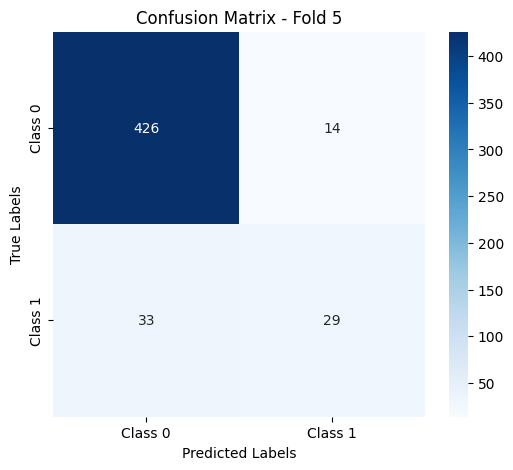


Average Validation Accuracy: 0.8846
Experiment 6 completed.

Running Experiment 7 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 2.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7688, Val Loss: 0.6068, Train Acc: 0.7795, Val Acc: 0.8827
Epoch [2/50], Train Loss: 0.6630, Val Loss: 0.5182, Train Acc: 0.8309, Val Acc: 0.8469
Epoch [3/50], Train Loss: 0.5673, Val Loss: 0.4572, Train Acc: 0.8411, Val Acc: 0.8509
Epoch [4/50], Train Loss: 0.5074, Val Loss: 0.4336, Train Acc: 0.8468, Val Acc: 0.8509
Epoch [5/50], Train Loss: 0.4724, Val Loss: 0.4175, Train Acc: 0.8482, Val Acc: 0.8469
Epoch [6/50], Train Loss: 0.4436, Val Loss: 0.4156, Train Acc: 0.8597, Val Acc: 0.8429
Epoch [7/50], Train Loss: 0.4255, Val Loss: 0.4153, Train Acc: 0.8579, Val Acc: 0.8370
Epoch [8/50], Train Loss: 0.4093, Val Loss: 0.4020, Train Acc: 0.8654, Val Acc: 0.8489
Epoch [9/50], Train Loss: 0.3956, Val Loss: 0.4079, Train Acc: 0.8783, Val Acc: 0.8330
Epoch [10/50], Train Loss: 0.3810, Val Loss: 0.3950, Train Acc: 0.8783, Val Acc: 0.8549
Epoch [11/50], Train Loss: 0.3662, Val Loss: 0.3952, Train Acc: 0.8849, Val Acc: 0.8569
Epoch [12/50], Train Loss: 0.3613, Val Lo

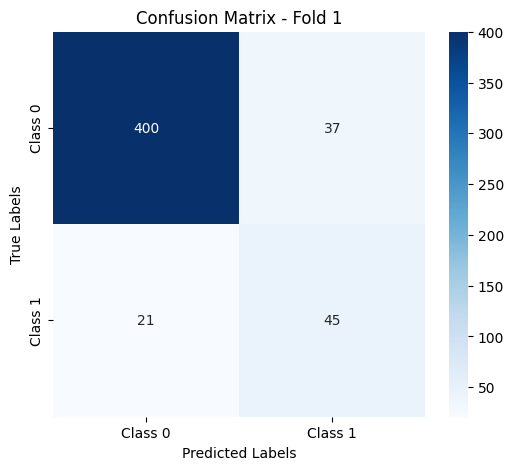

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7955, Val Loss: 0.6507, Train Acc: 0.7287, Val Acc: 0.8708
Epoch [2/50], Train Loss: 0.7010, Val Loss: 0.5555, Train Acc: 0.8107, Val Acc: 0.8847
Epoch [3/50], Train Loss: 0.6063, Val Loss: 0.4876, Train Acc: 0.8488, Val Acc: 0.8529
Epoch [4/50], Train Loss: 0.5351, Val Loss: 0.4457, Train Acc: 0.8533, Val Acc: 0.8449
Epoch [5/50], Train Loss: 0.4892, Val Loss: 0.4211, Train Acc: 0.8559, Val Acc: 0.8509
Epoch [6/50], Train Loss: 0.4633, Val Loss: 0.4105, Train Acc: 0.8599, Val Acc: 0.8549
Epoch [7/50], Train Loss: 0.4400, Val Loss: 0.4054, Train Acc: 0.8692, Val Acc: 0.8549
Epoch [8/50], Train Loss: 0.4202, Val Loss: 0.4019, Train Acc: 0.8754, Val Acc: 0.8569
Epoch [9/50], Train Loss: 0.4099, Val Loss: 0.4050, Train Acc: 0.8812, Val Acc: 0.8569
Epoch [10/50], Train Loss: 0.3932, Val Loss: 0.4033, Train Acc: 0.8865, Val Acc: 0.8628
Epoch [11/50], Train Loss: 0.3840, Val Loss: 0.4052, Train Acc: 0.8923, Val Acc: 0.8608
Epoch [12/50], Train Loss: 0.3769, Val Lo

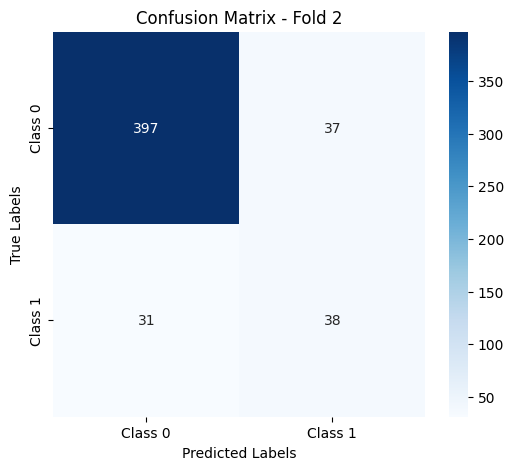

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.8064, Val Loss: 0.6378, Train Acc: 0.6273, Val Acc: 0.8187
Epoch [2/50], Train Loss: 0.6807, Val Loss: 0.5312, Train Acc: 0.8238, Val Acc: 0.8247
Epoch [3/50], Train Loss: 0.5783, Val Loss: 0.4680, Train Acc: 0.8419, Val Acc: 0.8287
Epoch [4/50], Train Loss: 0.5136, Val Loss: 0.4532, Train Acc: 0.8524, Val Acc: 0.8247
Epoch [5/50], Train Loss: 0.4789, Val Loss: 0.4319, Train Acc: 0.8542, Val Acc: 0.8386
Epoch [6/50], Train Loss: 0.4536, Val Loss: 0.4121, Train Acc: 0.8612, Val Acc: 0.8506
Epoch [7/50], Train Loss: 0.4341, Val Loss: 0.4016, Train Acc: 0.8705, Val Acc: 0.8506
Epoch [8/50], Train Loss: 0.4211, Val Loss: 0.3921, Train Acc: 0.8780, Val Acc: 0.8606
Epoch [9/50], Train Loss: 0.4075, Val Loss: 0.3974, Train Acc: 0.8797, Val Acc: 0.8586
Epoch [10/50], Train Loss: 0.4015, Val Loss: 0.3827, Train Acc: 0.8819, Val Acc: 0.8665
Epoch [11/50], Train Loss: 0.3870, Val Loss: 0.3836, Train Acc: 0.8824, Val Acc: 0.8665
Epoch [12/50], Train Loss: 0.3749, Val Lo

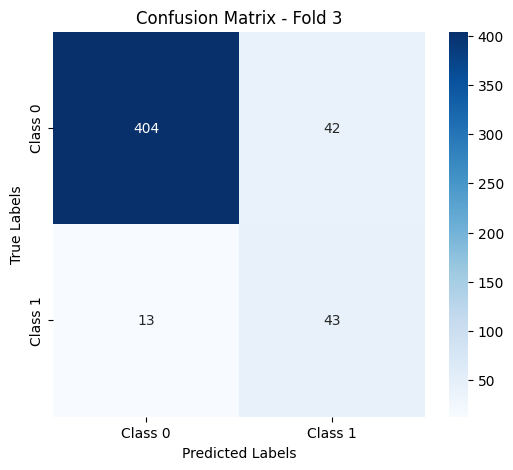

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7722, Val Loss: 0.6152, Train Acc: 0.7689, Val Acc: 0.8606
Epoch [2/50], Train Loss: 0.6711, Val Loss: 0.5407, Train Acc: 0.8166, Val Acc: 0.8207
Epoch [3/50], Train Loss: 0.5864, Val Loss: 0.4871, Train Acc: 0.8277, Val Acc: 0.8247
Epoch [4/50], Train Loss: 0.5288, Val Loss: 0.4694, Train Acc: 0.8285, Val Acc: 0.8108
Epoch [5/50], Train Loss: 0.4881, Val Loss: 0.4510, Train Acc: 0.8431, Val Acc: 0.8227
Epoch [6/50], Train Loss: 0.4639, Val Loss: 0.4446, Train Acc: 0.8542, Val Acc: 0.8287
Epoch [7/50], Train Loss: 0.4385, Val Loss: 0.4366, Train Acc: 0.8630, Val Acc: 0.8327
Epoch [8/50], Train Loss: 0.4201, Val Loss: 0.4368, Train Acc: 0.8639, Val Acc: 0.8327
Epoch [9/50], Train Loss: 0.4050, Val Loss: 0.4427, Train Acc: 0.8758, Val Acc: 0.8247
Epoch [10/50], Train Loss: 0.3872, Val Loss: 0.4436, Train Acc: 0.8789, Val Acc: 0.8287
Epoch [11/50], Train Loss: 0.3730, Val Loss: 0.4436, Train Acc: 0.8842, Val Acc: 0.8307
Epoch [12/50], Train Loss: 0.3607, Val Lo

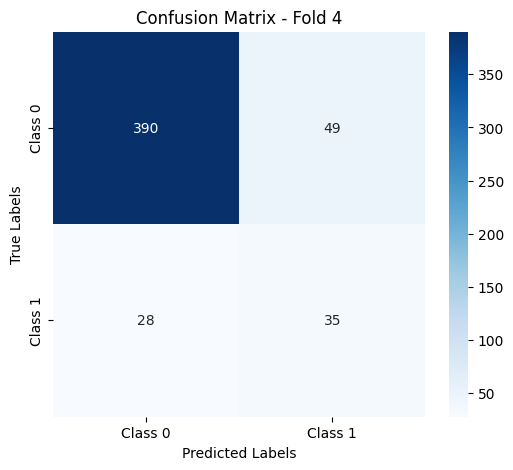

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.8243, Val Loss: 0.6675, Train Acc: 0.5760, Val Acc: 0.8048
Epoch [2/50], Train Loss: 0.6934, Val Loss: 0.5555, Train Acc: 0.8211, Val Acc: 0.8466
Epoch [3/50], Train Loss: 0.5978, Val Loss: 0.4957, Train Acc: 0.8379, Val Acc: 0.8307
Epoch [4/50], Train Loss: 0.5381, Val Loss: 0.4618, Train Acc: 0.8467, Val Acc: 0.8386
Epoch [5/50], Train Loss: 0.5038, Val Loss: 0.4372, Train Acc: 0.8525, Val Acc: 0.8526
Epoch [6/50], Train Loss: 0.4730, Val Loss: 0.4292, Train Acc: 0.8626, Val Acc: 0.8526
Epoch [7/50], Train Loss: 0.4547, Val Loss: 0.4188, Train Acc: 0.8644, Val Acc: 0.8546
Epoch [8/50], Train Loss: 0.4332, Val Loss: 0.4121, Train Acc: 0.8772, Val Acc: 0.8606
Epoch [9/50], Train Loss: 0.4208, Val Loss: 0.4066, Train Acc: 0.8785, Val Acc: 0.8645
Epoch [10/50], Train Loss: 0.4090, Val Loss: 0.4115, Train Acc: 0.8856, Val Acc: 0.8665
Epoch [11/50], Train Loss: 0.3965, Val Loss: 0.4078, Train Acc: 0.8887, Val Acc: 0.8625
Epoch [12/50], Train Loss: 0.3784, Val Lo

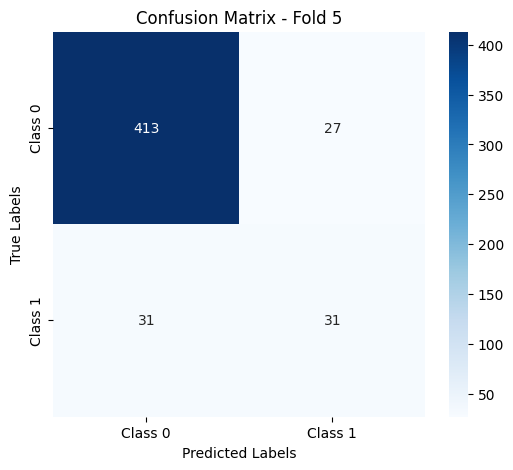


Average Validation Accuracy: 0.8742
Experiment 7 completed.

Running Experiment 8 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': False}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6515, Val Loss: 0.5071, Train Acc: 0.6346, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.4484, Val Loss: 0.4001, Train Acc: 0.8756, Val Acc: 0.8688
Epoch [3/50], Train Loss: 0.3797, Val Loss: 0.3652, Train Acc: 0.8756, Val Acc: 0.8688
Epoch [4/50], Train Loss: 0.3472, Val Loss: 0.3344, Train Acc: 0.8756, Val Acc: 0.8708
Epoch [5/50], Train Loss: 0.3141, Val Loss: 0.3051, Train Acc: 0.8756, Val Acc: 0.8767
Epoch [6/50], Train Loss: 0.2864, Val Loss: 0.2852, Train Acc: 0.8880, Val Acc: 0.8827
Epoch [7/50], Train Loss: 0.2677, Val Loss: 0.2718, Train Acc: 0.9009, Val Acc: 0.8907
Epoch [8/50], Train Loss: 0.2528, Val Loss: 0.2662, Train Acc: 0.9009, Val Acc: 0.8887
Epoch [9/50], Train Loss: 0.2459, Val Loss: 0.2570, Train Acc: 0.9039, Val Acc: 0.9085
Epoch [10/50], Train Loss: 0.2354, Val Loss: 0.2526, Train Acc: 0.9124, Val Acc: 0.9125
Epoch [11/50], Train Loss: 0.2292, Val Loss: 0.2505, Train Acc: 0.9114, Val Acc: 0.9066
Epoch [12/50], Train Loss: 0.2249, Val Lo

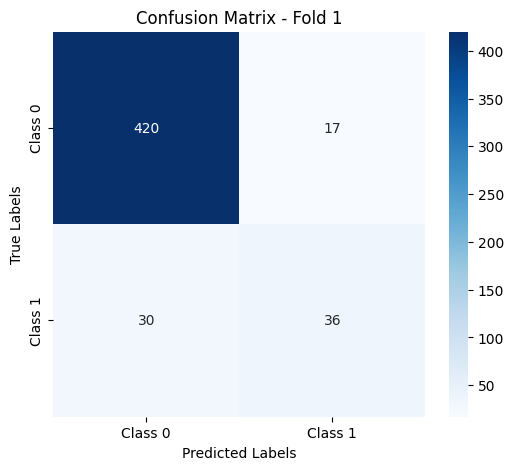

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5533, Val Loss: 0.4431, Train Acc: 0.7979, Val Acc: 0.8628
Epoch [2/50], Train Loss: 0.3945, Val Loss: 0.3727, Train Acc: 0.8771, Val Acc: 0.8628
Epoch [3/50], Train Loss: 0.3436, Val Loss: 0.3355, Train Acc: 0.8771, Val Acc: 0.8628
Epoch [4/50], Train Loss: 0.3119, Val Loss: 0.2990, Train Acc: 0.8790, Val Acc: 0.8668
Epoch [5/50], Train Loss: 0.2841, Val Loss: 0.2716, Train Acc: 0.8870, Val Acc: 0.8847
Epoch [6/50], Train Loss: 0.2625, Val Loss: 0.2566, Train Acc: 0.9004, Val Acc: 0.8946
Epoch [7/50], Train Loss: 0.2493, Val Loss: 0.2494, Train Acc: 0.9004, Val Acc: 0.8946
Epoch [8/50], Train Loss: 0.2410, Val Loss: 0.2448, Train Acc: 0.9029, Val Acc: 0.8966
Epoch [9/50], Train Loss: 0.2335, Val Loss: 0.2418, Train Acc: 0.9039, Val Acc: 0.8966
Epoch [10/50], Train Loss: 0.2255, Val Loss: 0.2383, Train Acc: 0.9069, Val Acc: 0.8946
Epoch [11/50], Train Loss: 0.2186, Val Loss: 0.2431, Train Acc: 0.9159, Val Acc: 0.8946
Epoch [12/50], Train Loss: 0.2142, Val Lo

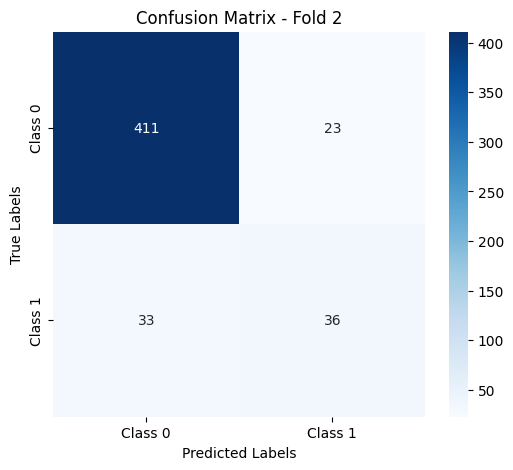

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5838, Val Loss: 0.4544, Train Acc: 0.7736, Val Acc: 0.8884
Epoch [2/50], Train Loss: 0.4155, Val Loss: 0.3559, Train Acc: 0.8706, Val Acc: 0.8884
Epoch [3/50], Train Loss: 0.3575, Val Loss: 0.3181, Train Acc: 0.8711, Val Acc: 0.8865
Epoch [4/50], Train Loss: 0.3240, Val Loss: 0.2920, Train Acc: 0.8716, Val Acc: 0.8904
Epoch [5/50], Train Loss: 0.2944, Val Loss: 0.2747, Train Acc: 0.8836, Val Acc: 0.9124
Epoch [6/50], Train Loss: 0.2743, Val Loss: 0.2639, Train Acc: 0.8945, Val Acc: 0.9024
Epoch [7/50], Train Loss: 0.2598, Val Loss: 0.2576, Train Acc: 0.8995, Val Acc: 0.9024
Epoch [8/50], Train Loss: 0.2466, Val Loss: 0.2502, Train Acc: 0.9025, Val Acc: 0.9024
Epoch [9/50], Train Loss: 0.2373, Val Loss: 0.2492, Train Acc: 0.9055, Val Acc: 0.8964
Epoch [10/50], Train Loss: 0.2304, Val Loss: 0.2388, Train Acc: 0.9114, Val Acc: 0.9024
Epoch [11/50], Train Loss: 0.2258, Val Loss: 0.2400, Train Acc: 0.9119, Val Acc: 0.8984
Epoch [12/50], Train Loss: 0.2166, Val Lo

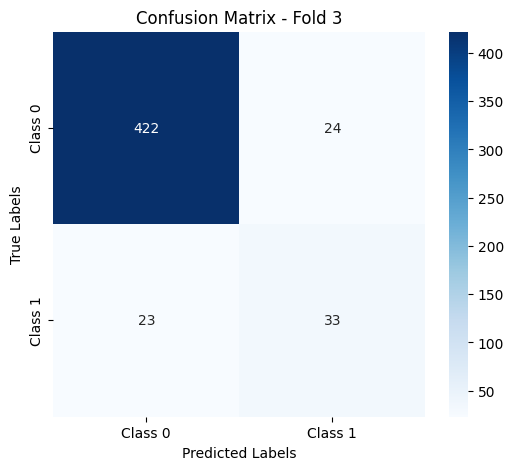

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5645, Val Loss: 0.4454, Train Acc: 0.8104, Val Acc: 0.8745
Epoch [2/50], Train Loss: 0.4091, Val Loss: 0.3729, Train Acc: 0.8741, Val Acc: 0.8745
Epoch [3/50], Train Loss: 0.3629, Val Loss: 0.3464, Train Acc: 0.8741, Val Acc: 0.8745
Epoch [4/50], Train Loss: 0.3344, Val Loss: 0.3217, Train Acc: 0.8741, Val Acc: 0.8745
Epoch [5/50], Train Loss: 0.3041, Val Loss: 0.2999, Train Acc: 0.8776, Val Acc: 0.8805
Epoch [6/50], Train Loss: 0.2807, Val Loss: 0.2845, Train Acc: 0.8900, Val Acc: 0.8865
Epoch [7/50], Train Loss: 0.2619, Val Loss: 0.2752, Train Acc: 0.9015, Val Acc: 0.8865
Epoch [8/50], Train Loss: 0.2488, Val Loss: 0.2691, Train Acc: 0.9050, Val Acc: 0.8825
Epoch [9/50], Train Loss: 0.2383, Val Loss: 0.2658, Train Acc: 0.9065, Val Acc: 0.8884
Epoch [10/50], Train Loss: 0.2289, Val Loss: 0.2636, Train Acc: 0.9119, Val Acc: 0.8884
Epoch [11/50], Train Loss: 0.2184, Val Loss: 0.2623, Train Acc: 0.9174, Val Acc: 0.8924
Epoch [12/50], Train Loss: 0.2152, Val Lo

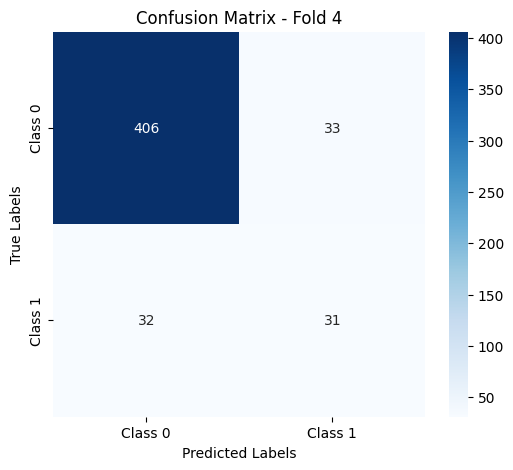

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5280, Val Loss: 0.4183, Train Acc: 0.8413, Val Acc: 0.8765
Epoch [2/50], Train Loss: 0.3829, Val Loss: 0.3463, Train Acc: 0.8736, Val Acc: 0.8765
Epoch [3/50], Train Loss: 0.3277, Val Loss: 0.3099, Train Acc: 0.8741, Val Acc: 0.8805
Epoch [4/50], Train Loss: 0.2922, Val Loss: 0.2857, Train Acc: 0.8876, Val Acc: 0.8884
Epoch [5/50], Train Loss: 0.2677, Val Loss: 0.2732, Train Acc: 0.8970, Val Acc: 0.8944
Epoch [6/50], Train Loss: 0.2515, Val Loss: 0.2653, Train Acc: 0.9055, Val Acc: 0.8944
Epoch [7/50], Train Loss: 0.2386, Val Loss: 0.2620, Train Acc: 0.9124, Val Acc: 0.8944
Epoch [8/50], Train Loss: 0.2319, Val Loss: 0.2590, Train Acc: 0.9129, Val Acc: 0.8865
Epoch [9/50], Train Loss: 0.2269, Val Loss: 0.2562, Train Acc: 0.9164, Val Acc: 0.8884
Epoch [10/50], Train Loss: 0.2192, Val Loss: 0.2595, Train Acc: 0.9149, Val Acc: 0.8944
Epoch [11/50], Train Loss: 0.2199, Val Loss: 0.2577, Train Acc: 0.9114, Val Acc: 0.8964
Epoch [12/50], Train Loss: 0.2125, Val Lo

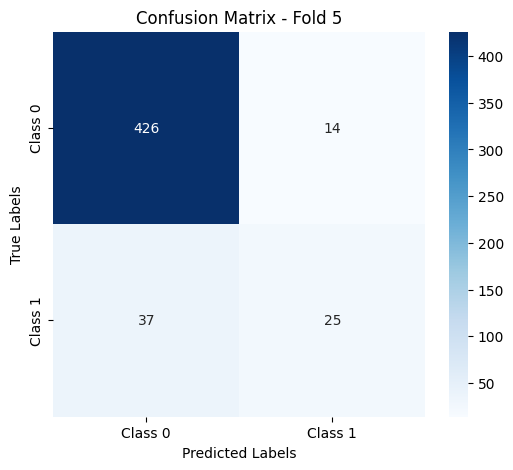


Average Validation Accuracy: 0.8941
Experiment 8 completed.

Running Experiment 9 with parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 4, 'num_layers': 6, 'pos_weight': 1.0, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5701, Val Loss: 0.3971, Train Acc: 0.7238, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.4404, Val Loss: 0.3406, Train Acc: 0.7981, Val Acc: 0.8807
Epoch [3/50], Train Loss: 0.3785, Val Loss: 0.3024, Train Acc: 0.8411, Val Acc: 0.8847
Epoch [4/50], Train Loss: 0.3442, Val Loss: 0.2860, Train Acc: 0.8601, Val Acc: 0.8907
Epoch [5/50], Train Loss: 0.3208, Val Loss: 0.2887, Train Acc: 0.8712, Val Acc: 0.8688
Epoch [6/50], Train Loss: 0.3027, Val Loss: 0.2724, Train Acc: 0.8809, Val Acc: 0.9006
Epoch [7/50], Train Loss: 0.2871, Val Loss: 0.2771, Train Acc: 0.8840, Val Acc: 0.8807
Epoch [8/50], Train Loss: 0.2801, Val Loss: 0.2738, Train Acc: 0.8880, Val Acc: 0.8807
Epoch [9/50], Train Loss: 0.2677, Val Loss: 0.2778, Train Acc: 0.8977, Val Acc: 0.8767
Epoch [10/50], Train Loss: 0.2592, Val Loss: 0.2704, Train Acc: 0.9004, Val Acc: 0.8867
Epoch [11/50], Train Loss: 0.2537, Val Loss: 0.2743, Train Acc: 0.9044, Val Acc: 0.8787
Epoch [12/50], Train Loss: 0.2418, Val Lo

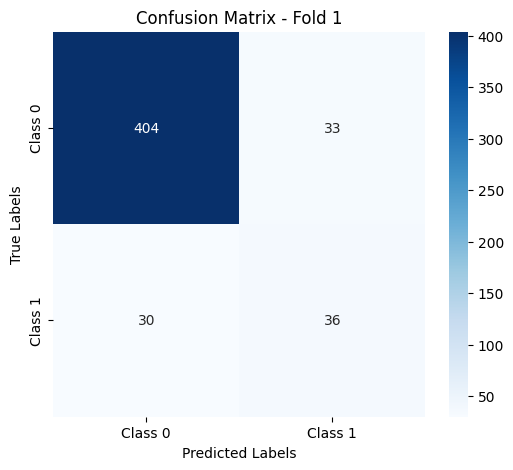

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.6055, Val Loss: 0.4544, Train Acc: 0.7008, Val Acc: 0.8628
Epoch [2/50], Train Loss: 0.4913, Val Loss: 0.3796, Train Acc: 0.7868, Val Acc: 0.8767
Epoch [3/50], Train Loss: 0.4158, Val Loss: 0.3241, Train Acc: 0.8338, Val Acc: 0.8887
Epoch [4/50], Train Loss: 0.3609, Val Loss: 0.3048, Train Acc: 0.8626, Val Acc: 0.8827
Epoch [5/50], Train Loss: 0.3345, Val Loss: 0.2921, Train Acc: 0.8701, Val Acc: 0.8767
Epoch [6/50], Train Loss: 0.3155, Val Loss: 0.2959, Train Acc: 0.8812, Val Acc: 0.8668
Epoch [7/50], Train Loss: 0.3040, Val Loss: 0.2757, Train Acc: 0.8848, Val Acc: 0.8827
Epoch [8/50], Train Loss: 0.2862, Val Loss: 0.2711, Train Acc: 0.8967, Val Acc: 0.8827
Epoch [9/50], Train Loss: 0.2808, Val Loss: 0.2689, Train Acc: 0.8985, Val Acc: 0.8807
Epoch [10/50], Train Loss: 0.2777, Val Loss: 0.2728, Train Acc: 0.8958, Val Acc: 0.8787
Epoch [11/50], Train Loss: 0.2664, Val Loss: 0.2649, Train Acc: 0.9020, Val Acc: 0.8966
Epoch [12/50], Train Loss: 0.2609, Val Lo

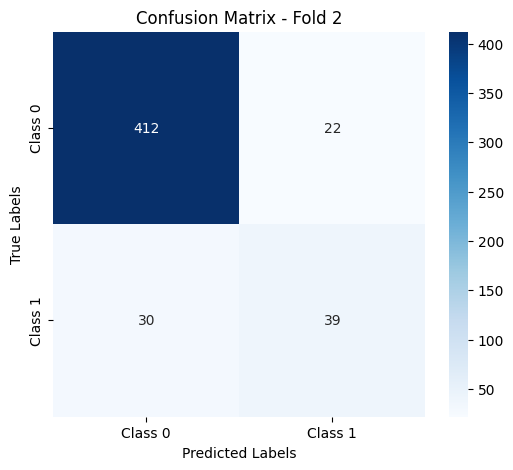

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5597, Val Loss: 0.4061, Train Acc: 0.7608, Val Acc: 0.8904
Epoch [2/50], Train Loss: 0.4588, Val Loss: 0.3373, Train Acc: 0.7863, Val Acc: 0.8785
Epoch [3/50], Train Loss: 0.3961, Val Loss: 0.2995, Train Acc: 0.8388, Val Acc: 0.8845
Epoch [4/50], Train Loss: 0.3580, Val Loss: 0.2935, Train Acc: 0.8608, Val Acc: 0.8705
Epoch [5/50], Train Loss: 0.3337, Val Loss: 0.2706, Train Acc: 0.8700, Val Acc: 0.8884
Epoch [6/50], Train Loss: 0.3185, Val Loss: 0.2736, Train Acc: 0.8775, Val Acc: 0.8845
Epoch [7/50], Train Loss: 0.3039, Val Loss: 0.2672, Train Acc: 0.8837, Val Acc: 0.8884
Epoch [8/50], Train Loss: 0.2928, Val Loss: 0.2749, Train Acc: 0.8903, Val Acc: 0.8884
Epoch [9/50], Train Loss: 0.2779, Val Loss: 0.2643, Train Acc: 0.8991, Val Acc: 0.8884
Epoch [10/50], Train Loss: 0.2708, Val Loss: 0.2608, Train Acc: 0.9009, Val Acc: 0.8964
Epoch [11/50], Train Loss: 0.2596, Val Loss: 0.2513, Train Acc: 0.9048, Val Acc: 0.8984
Epoch [12/50], Train Loss: 0.2511, Val Lo

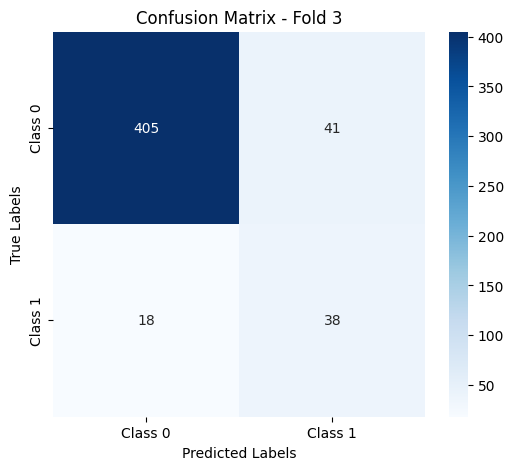

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5641, Val Loss: 0.4233, Train Acc: 0.7499, Val Acc: 0.8725
Epoch [2/50], Train Loss: 0.4403, Val Loss: 0.3677, Train Acc: 0.7976, Val Acc: 0.8546
Epoch [3/50], Train Loss: 0.3760, Val Loss: 0.3371, Train Acc: 0.8475, Val Acc: 0.8586
Epoch [4/50], Train Loss: 0.3410, Val Loss: 0.3178, Train Acc: 0.8696, Val Acc: 0.8606
Epoch [5/50], Train Loss: 0.3171, Val Loss: 0.3148, Train Acc: 0.8767, Val Acc: 0.8586
Epoch [6/50], Train Loss: 0.3046, Val Loss: 0.3095, Train Acc: 0.8856, Val Acc: 0.8606
Epoch [7/50], Train Loss: 0.2900, Val Loss: 0.3107, Train Acc: 0.8917, Val Acc: 0.8566
Epoch [8/50], Train Loss: 0.2794, Val Loss: 0.2939, Train Acc: 0.8966, Val Acc: 0.8705
Epoch [9/50], Train Loss: 0.2662, Val Loss: 0.2964, Train Acc: 0.9054, Val Acc: 0.8645
Epoch [10/50], Train Loss: 0.2631, Val Loss: 0.2944, Train Acc: 0.9006, Val Acc: 0.8725
Epoch [11/50], Train Loss: 0.2497, Val Loss: 0.3009, Train Acc: 0.9081, Val Acc: 0.8645
Epoch [12/50], Train Loss: 0.2412, Val Lo

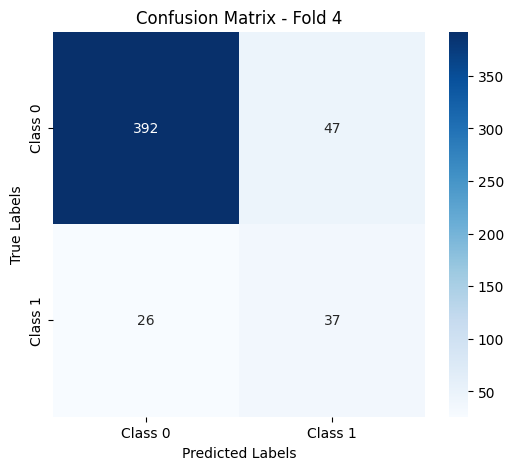

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.5525, Val Loss: 0.4039, Train Acc: 0.7637, Val Acc: 0.8785
Epoch [2/50], Train Loss: 0.4393, Val Loss: 0.3426, Train Acc: 0.7990, Val Acc: 0.8785
Epoch [3/50], Train Loss: 0.3708, Val Loss: 0.3102, Train Acc: 0.8454, Val Acc: 0.8705
Epoch [4/50], Train Loss: 0.3340, Val Loss: 0.2953, Train Acc: 0.8653, Val Acc: 0.8805
Epoch [5/50], Train Loss: 0.3134, Val Loss: 0.2915, Train Acc: 0.8750, Val Acc: 0.8785
Epoch [6/50], Train Loss: 0.3014, Val Loss: 0.2847, Train Acc: 0.8843, Val Acc: 0.8865
Epoch [7/50], Train Loss: 0.2889, Val Loss: 0.2836, Train Acc: 0.8900, Val Acc: 0.8825
Epoch [8/50], Train Loss: 0.2779, Val Loss: 0.2852, Train Acc: 0.8984, Val Acc: 0.8825
Epoch [9/50], Train Loss: 0.2698, Val Loss: 0.2885, Train Acc: 0.8997, Val Acc: 0.8845
Epoch [10/50], Train Loss: 0.2657, Val Loss: 0.2931, Train Acc: 0.9064, Val Acc: 0.8825
Epoch [11/50], Train Loss: 0.2561, Val Loss: 0.2798, Train Acc: 0.9117, Val Acc: 0.8904
Epoch [12/50], Train Loss: 0.2502, Val Lo

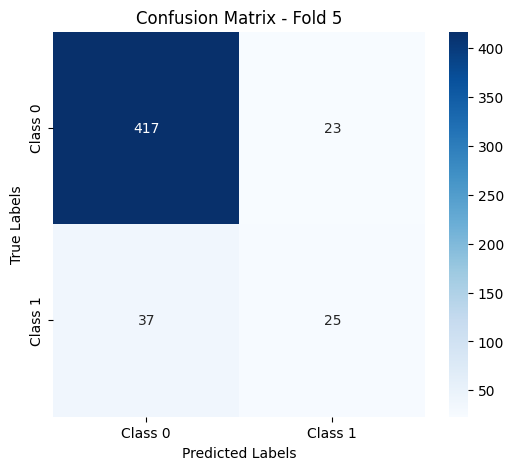


Average Validation Accuracy: 0.8778
Experiment 9 completed.

Running Experiment 10 with parameters: {'learning_rate': 5e-06, 'batch_size': 16, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 4, 'pos_weight': 1.5, 'neg_weight': 1.0, 'augment_minority_class': True}
FOLD 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7175, Val Loss: 0.6107, Train Acc: 0.7251, Val Acc: 0.8688
Epoch [2/50], Train Loss: 0.6539, Val Loss: 0.5384, Train Acc: 0.7933, Val Acc: 0.8807
Epoch [3/50], Train Loss: 0.6024, Val Loss: 0.4848, Train Acc: 0.8048, Val Acc: 0.8926
Epoch [4/50], Train Loss: 0.5521, Val Loss: 0.4464, Train Acc: 0.8287, Val Acc: 0.8827
Epoch [5/50], Train Loss: 0.5106, Val Loss: 0.4165, Train Acc: 0.8420, Val Acc: 0.8708
Epoch [6/50], Train Loss: 0.4723, Val Loss: 0.3949, Train Acc: 0.8566, Val Acc: 0.8748
Epoch [7/50], Train Loss: 0.4506, Val Loss: 0.3781, Train Acc: 0.8579, Val Acc: 0.8728
Epoch [8/50], Train Loss: 0.4294, Val Loss: 0.3675, Train Acc: 0.8676, Val Acc: 0.8708
Epoch [9/50], Train Loss: 0.4163, Val Loss: 0.3598, Train Acc: 0.8672, Val Acc: 0.8748
Epoch [10/50], Train Loss: 0.4057, Val Loss: 0.3485, Train Acc: 0.8641, Val Acc: 0.8807
Epoch [11/50], Train Loss: 0.3912, Val Loss: 0.3455, Train Acc: 0.8738, Val Acc: 0.8728
Epoch [12/50], Train Loss: 0.3759, Val Lo

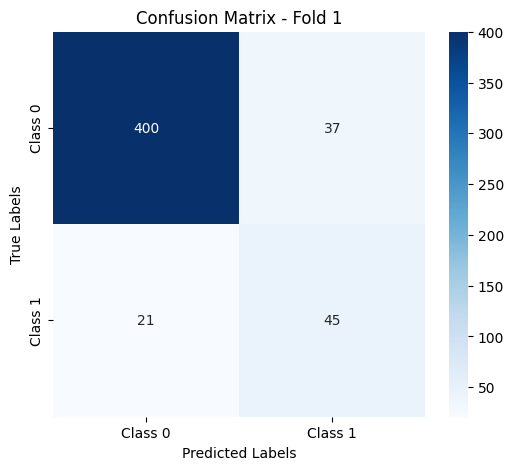

FOLD 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7301, Val Loss: 0.6216, Train Acc: 0.6964, Val Acc: 0.8449
Epoch [2/50], Train Loss: 0.6617, Val Loss: 0.5478, Train Acc: 0.7793, Val Acc: 0.8608
Epoch [3/50], Train Loss: 0.6131, Val Loss: 0.4960, Train Acc: 0.7881, Val Acc: 0.8608
Epoch [4/50], Train Loss: 0.5671, Val Loss: 0.4545, Train Acc: 0.8063, Val Acc: 0.8668
Epoch [5/50], Train Loss: 0.5279, Val Loss: 0.4216, Train Acc: 0.8249, Val Acc: 0.8668
Epoch [6/50], Train Loss: 0.4953, Val Loss: 0.3962, Train Acc: 0.8431, Val Acc: 0.8807
Epoch [7/50], Train Loss: 0.4677, Val Loss: 0.3772, Train Acc: 0.8493, Val Acc: 0.8767
Epoch [8/50], Train Loss: 0.4451, Val Loss: 0.3631, Train Acc: 0.8555, Val Acc: 0.8688
Epoch [9/50], Train Loss: 0.4263, Val Loss: 0.3552, Train Acc: 0.8542, Val Acc: 0.8648
Epoch [10/50], Train Loss: 0.4161, Val Loss: 0.3500, Train Acc: 0.8515, Val Acc: 0.8648
Epoch [11/50], Train Loss: 0.4027, Val Loss: 0.3436, Train Acc: 0.8608, Val Acc: 0.8688
Epoch [12/50], Train Loss: 0.3902, Val Lo

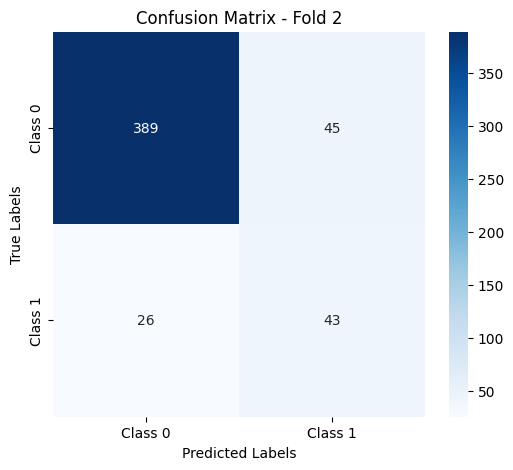

FOLD 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7183, Val Loss: 0.6042, Train Acc: 0.7300, Val Acc: 0.8606
Epoch [2/50], Train Loss: 0.6517, Val Loss: 0.5265, Train Acc: 0.7938, Val Acc: 0.8685
Epoch [3/50], Train Loss: 0.5977, Val Loss: 0.4695, Train Acc: 0.8088, Val Acc: 0.8865
Epoch [4/50], Train Loss: 0.5519, Val Loss: 0.4328, Train Acc: 0.8264, Val Acc: 0.8745
Epoch [5/50], Train Loss: 0.5118, Val Loss: 0.4051, Train Acc: 0.8335, Val Acc: 0.8645
Epoch [6/50], Train Loss: 0.4821, Val Loss: 0.3867, Train Acc: 0.8463, Val Acc: 0.8566
Epoch [7/50], Train Loss: 0.4570, Val Loss: 0.3701, Train Acc: 0.8573, Val Acc: 0.8625
Epoch [8/50], Train Loss: 0.4362, Val Loss: 0.3661, Train Acc: 0.8595, Val Acc: 0.8546
Epoch [9/50], Train Loss: 0.4249, Val Loss: 0.3510, Train Acc: 0.8542, Val Acc: 0.8566
Epoch [10/50], Train Loss: 0.4122, Val Loss: 0.3415, Train Acc: 0.8617, Val Acc: 0.8586
Epoch [11/50], Train Loss: 0.4032, Val Loss: 0.3379, Train Acc: 0.8652, Val Acc: 0.8606
Epoch [12/50], Train Loss: 0.3902, Val Lo

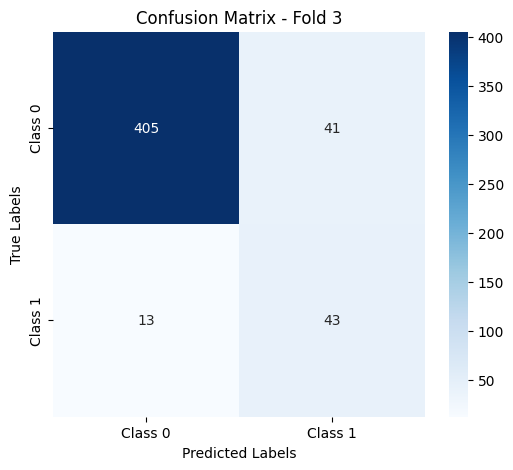

FOLD 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7289, Val Loss: 0.6233, Train Acc: 0.6876, Val Acc: 0.8426
Epoch [2/50], Train Loss: 0.6495, Val Loss: 0.5421, Train Acc: 0.7914, Val Acc: 0.8625
Epoch [3/50], Train Loss: 0.5914, Val Loss: 0.4911, Train Acc: 0.8038, Val Acc: 0.8765
Epoch [4/50], Train Loss: 0.5403, Val Loss: 0.4591, Train Acc: 0.8277, Val Acc: 0.8645
Epoch [5/50], Train Loss: 0.4967, Val Loss: 0.4356, Train Acc: 0.8489, Val Acc: 0.8526
Epoch [6/50], Train Loss: 0.4651, Val Loss: 0.4195, Train Acc: 0.8555, Val Acc: 0.8506
Epoch [7/50], Train Loss: 0.4363, Val Loss: 0.4064, Train Acc: 0.8688, Val Acc: 0.8367
Epoch [8/50], Train Loss: 0.4167, Val Loss: 0.3979, Train Acc: 0.8674, Val Acc: 0.8466
Epoch [9/50], Train Loss: 0.4050, Val Loss: 0.3871, Train Acc: 0.8705, Val Acc: 0.8446
Epoch [10/50], Train Loss: 0.3932, Val Loss: 0.3831, Train Acc: 0.8674, Val Acc: 0.8486
Epoch [11/50], Train Loss: 0.3828, Val Loss: 0.3826, Train Acc: 0.8723, Val Acc: 0.8466
Epoch [12/50], Train Loss: 0.3762, Val Lo

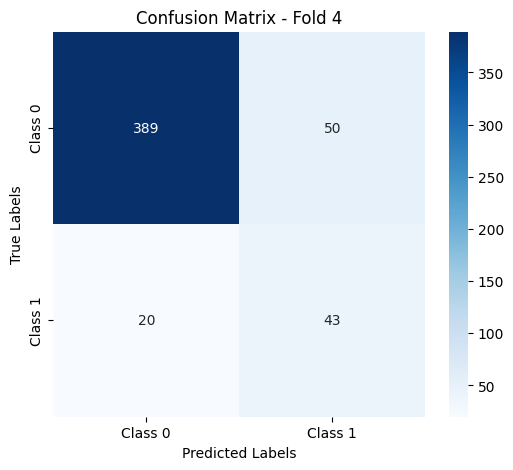

FOLD 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 0.7254, Val Loss: 0.6202, Train Acc: 0.7036, Val Acc: 0.8685
Epoch [2/50], Train Loss: 0.6695, Val Loss: 0.5586, Train Acc: 0.7734, Val Acc: 0.8825
Epoch [3/50], Train Loss: 0.6251, Val Loss: 0.5123, Train Acc: 0.7964, Val Acc: 0.8884
Epoch [4/50], Train Loss: 0.5831, Val Loss: 0.4742, Train Acc: 0.8149, Val Acc: 0.8725
Epoch [5/50], Train Loss: 0.5428, Val Loss: 0.4437, Train Acc: 0.8317, Val Acc: 0.8705
Epoch [6/50], Train Loss: 0.5096, Val Loss: 0.4184, Train Acc: 0.8516, Val Acc: 0.8586
Epoch [7/50], Train Loss: 0.4804, Val Loss: 0.4021, Train Acc: 0.8587, Val Acc: 0.8586
Epoch [8/50], Train Loss: 0.4585, Val Loss: 0.3886, Train Acc: 0.8595, Val Acc: 0.8506
Epoch [9/50], Train Loss: 0.4408, Val Loss: 0.3788, Train Acc: 0.8613, Val Acc: 0.8586
Epoch [10/50], Train Loss: 0.4253, Val Loss: 0.3683, Train Acc: 0.8666, Val Acc: 0.8645
Epoch [11/50], Train Loss: 0.4137, Val Loss: 0.3637, Train Acc: 0.8684, Val Acc: 0.8725
Epoch [12/50], Train Loss: 0.3999, Val Lo

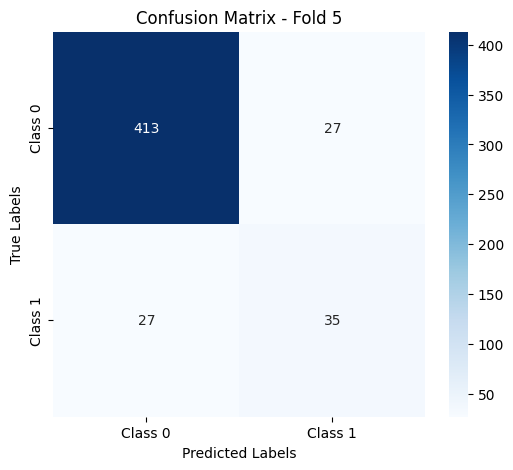


Average Validation Accuracy: 0.8778
Experiment 10 completed.



In [51]:
# List of experiments
experiments = [
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-4, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 32, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 256, "num_heads": 8, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 4, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 6, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 2.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": False},
    {"learning_rate": 1e-5, "batch_size": 16, "hidden_dim": 128, "num_heads": 4, "num_layers": 6, "pos_weight": 1.0, "neg_weight": 1.0, "augment_minority_class": True},
    {"learning_rate": 5e-6, "batch_size": 16, "hidden_dim": 128, "num_heads": 8, "num_layers": 4, "pos_weight": 1.5, "neg_weight": 1.0, "augment_minority_class": True}
]

# Run each experiment
experiment_results = []

for i, exp in enumerate(experiments, start=1):
    print(f"Running Experiment {i} with parameters: {exp}")

    # Run training and evaluation with specified parameters
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(
        dataset=dataset,
        device=device,
        num_epochs=50,
        batch_size=exp["batch_size"],
        learning_rate=exp["learning_rate"],
        hidden_dim=exp["hidden_dim"],
        num_heads=exp["num_heads"],
        num_layers=exp["num_layers"],
        pos_weight=exp["pos_weight"],
        neg_weight=exp["neg_weight"],
        k_folds=5,
        augment_minority_class=exp["augment_minority_class"]
    )

    # Collect results
    experiment_results.append({
        "Experiment": i,
        "Parameters": exp,
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Train Accuracy": train_accuracies,
        "Validation Accuracy": val_accuracies
    })

    print(f"Experiment {i} completed.\n")
